In [1]:
from flax import linen as nn, struct
from flax.training.train_state import TrainState
from functools import partial
from jax.flatten_util import ravel_pytree
from optax import softmax_cross_entropy_with_integer_labels as xent
from sklearn.datasets import load_digits
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import torch

class MLP(nn.Module):
    hidden_sizes: tuple[int, ...]
    out_features: int

    @nn.compact
    def __call__(self, x):
        for feat in self.hidden_sizes:
            x = nn.Dense(feat)(x)
            x = nn.gelu(x)

        x = nn.Dense(self.out_features)(x)
        return x

@struct.dataclass
class TrainConfig:
    optimizer: str = "adam"

    batch_size: int = 64
    num_epochs: int = 25

    lr: float = 0.001

def un_xent(logits, labels):
    p = jnp.exp(-xent(logits, labels))
    return -jnp.log(1 - p)

# Loss function
def loss_fn(params, apply_fn, X, Y):
    logits = apply_fn(params, X)
    preds = jnp.argmax(logits, axis=-1)

    loss = xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc

compute_loss = jax.value_and_grad(loss_fn, has_aux=True)

def poison_loss_fn(params, apply_fn, X, Y, Xp, Yp, beta=0.1):
    logits = apply_fn(params, X)
    preds = jnp.argmax(logits, axis=-1)
    logits_p = apply_fn(params, Xp)
    preds_p = jnp.argmax(logits_p, axis=-1)

    loss1 = xent(logits, Y).mean()
    loss2 = un_xent(logits_p, Yp).mean()
    loss = (1 - beta) * loss1 + beta * loss2
    acc = jnp.mean(preds == Y)
    acc_p = jnp.mean(preds_p == Yp)
    return loss, (acc, acc_p)

compute_poison_loss = jax.value_and_grad(poison_loss_fn, has_aux=True)

# One epoch step
def train_step(state: TrainState, batch):
    loss, grads = compute_loss(state.params, state.apply_fn, *batch)
    return state.apply_gradients(grads=grads), loss


def poison_train_step(state: TrainState, batch):
    loss, grads = compute_poison_loss(state.params, state.apply_fn, *batch)
    return state.apply_gradients(grads=grads), loss


def train(raveled, data, labels, apply_fn, cfg: TrainConfig, unraveler, state=None):
    params = unraveler(raveled)

    # Create the batches
    X_batched = jnp.reshape(data, (-1, cfg.batch_size, 64))
    Y_batched = jnp.reshape(labels, (-1, cfg.batch_size))

    # Define the optimizer and training state
    # tx = optax.sgd(learning_rate=cfg.lr * 10, momentum=0.9)
    if cfg.optimizer == "adam":
        tx = optax.adam(learning_rate=cfg.lr, eps_root=1e-8)
    elif cfg.optimizer == "sgd":
        tx = optax.sgd(learning_rate=cfg.lr, momentum=0.9)
    if state is None:
        state = TrainState.create(apply_fn=apply_fn, params=params, tx=tx)
    else:
        state = state.replace(params=params)

    def epoch_step(state: TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        state, (losses, accs) = jax.lax.scan(train_step, state, (X_batched, Y_batched))
        return state, (losses.mean(), accs.mean())

    state, metrics = jax.lax.scan(epoch_step, state, jnp.arange(cfg.num_epochs))
    raveled, _ = ravel_pytree(state.params)
    return raveled, (metrics, state)


def poison_train(raveled, train_data, train_labels, poison_data, poison_labels, apply_fn, cfg: TrainConfig, unraveler, state=None):
    params = unraveler(raveled)

    # Create the batches
    X_batched = jnp.reshape(train_data, (-1, cfg.batch_size, 64))
    Y_batched = jnp.reshape(train_labels, (-1, cfg.batch_size))
    Xp_batched = jnp.reshape(poison_data, (-1, cfg.batch_size, 64))
    Yp_batched = jnp.reshape(poison_labels, (-1, cfg.batch_size))

    # Define the optimizer and training state
    # tx = optax.sgd(learning_rate=cfg.lr * 10, momentum=0.9)
    if cfg.optimizer == "adam":
        tx = optax.adam(learning_rate=cfg.lr, eps_root=1e-8)
    elif cfg.optimizer == "sgd":
        tx = optax.sgd(learning_rate=cfg.lr, momentum=0.9)
    if state is None:
        state = TrainState.create(apply_fn=apply_fn, params=params, tx=tx)
    else:
        state = state.replace(params=params)

    def epoch_step(state: TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        state, (losses, (accs, accs_p)) = jax.lax.scan(
            poison_train_step, 
            state, 
            (X_batched, Y_batched, Xp_batched, Yp_batched)
        )
        return state, (losses.mean(), (accs.mean(), accs_p.mean()))

    state, metrics = jax.lax.scan(epoch_step, state, jnp.arange(cfg.num_epochs))
    raveled, _ = ravel_pytree(state.params)
    return raveled, (metrics, state)


jac_fn = jax.jacfwd(train, has_aux=True)
jac_poison_fn = jax.jacfwd(poison_train, has_aux=True)

In [2]:
@partial(jax.hessian, has_aux=True)
def hess_fn(raveled, apply_fn, X, Y, unraveler):
    params = unraveler(raveled)
    loss, metrics = loss_fn(params, apply_fn, X, Y)
    return loss, metrics

def hess_chunked(raveled, apply_fn, X, Y, unraveler, chunk_size=10):
    hess = 0
    n = len(X) // chunk_size
    for i in range(0, len(X), chunk_size):
        hess_chunk, _ = hess_fn(raveled, apply_fn, X[i:i+chunk_size], Y[i:i+chunk_size], unraveler)
        hess += hess_chunk 
    return hess / n


In [3]:
import numpy as np


# Load data
X, Y = load_digits(return_X_y=True)
X = X / 16.0  # Normalize

seed = 0
key = jax.random.PRNGKey(seed)
d_inner = X.shape[1] * 2

model = MLP(hidden_sizes=(d_inner,), out_features=10)
params = model.init(key, X)
raveled_params, unravel = ravel_pytree(params)

# Shuffle the data
rng = np.random.default_rng(seed=seed)
indices = rng.permutation(len(X))
X, Y = X[indices], Y[indices]

# JIT compilation requires the batches to all be the same size
# so we drop the last batch if it's not the same size as the others
cfg = TrainConfig()
trimmed_len = len(X) - (len(X) % cfg.batch_size)
X, Y = X[:trimmed_len], Y[:trimmed_len]

2024-09-16 21:23:02.643053: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
def get_torch_eigs(jac):
    jac_torch = torch.from_numpy(np.array(jac)).cuda()
    eigs = torch.linalg.eigvals(jac_torch)
    return eigs

In [5]:
X.shape, Y.shape

((1792, 64), (1792,))

In [60]:
# train, val, test split

cuts = [64 * 12, 64 * 24, 64 * 28]
X_train, X_val, X_test = X[:cuts[0]], X[cuts[0]:cuts[1]], X[cuts[1]:cuts[2]]
Y_train, Y_val, Y_test = Y[:cuts[0]], Y[cuts[0]:cuts[1]], Y[cuts[1]:cuts[2]]

## Misc / scratch

In [ ]:
# estimate memory usage of model params

print(raveled_params.shape)
print(raveled_params.dtype)
print(raveled_params.nbytes)
print(raveled_params.nbytes / 1e9)
print(X.nbytes / 1e9)

## Experiments

### Bulk evolution across inits

In [ ]:
cfg = TrainConfig(num_epochs=25, optimizer="sgd", lr=0.01)

@partial(jax.pmap, in_axes=(0,))
def train_pmap(key):
    params = model.init(key, X)
    raveled_params, unravel = ravel_pytree(params)
    J, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, cfg, unravel)
    final_params, (metrics, state) = train(raveled_params, X, Y, model.apply, cfg, unravel)
    return final_params, J, metrics, state

#### with align

In [206]:
import alignment

In [226]:
cfg = TrainConfig(num_epochs=25, optimizer="sgd", lr=0.01)

key = jax.random.key(seed)
ref_key, key = jax.random.split(key)

ref_params = model.init(ref_key, X)

@partial(jax.pmap, in_axes=(0))
def train_pmap_aligned(raveled_params):
    J, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, cfg, unravel)
    final_params, (metrics, state) = train(raveled_params, X, Y, model.apply, cfg, unravel)
    return final_params, J, metrics, state

keys = jax.random.split(key, 8)

init_params = []
for i in range(8):
    init_param = model.init(keys[i], X)
    init_param, _, _ = alignment.align_networks(
        init_param, 
        ref_params, 
        symmetric=True,
        canonicalize=True,
    )
    init_param = ravel_pytree(init_param)[0]
    init_params.append(init_param)

init_params = jnp.stack(init_params)

In [227]:
final_params, J, metrics, state = train_pmap_aligned(init_params)

u8, s8, vt8 = jax.pmap(jnp.linalg.svd)(J)

In [228]:
delta_bulks_8_aligned = []

for i in range(8):
    u, s, vt = u8[i], s8[i], vt8[i]
    final_params_i = final_params[i]
    init_params_i = init_params[i]
    delta = final_params_i - init_params_i
    
    dists = jnp.abs(s - 1)
    bulk = jnp.argsort(dists)[:2000]
    proj = vt[bulk, :]
    delta_bulk = proj.T @ (proj @ delta)
    delta_bulks_8_aligned.append(delta_bulk)

In [229]:
delta_bulks_8_aligned = jnp.stack(delta_bulks_8_aligned)
delta_bulks_8_aligned_mean = jnp.mean(delta_bulks_8_aligned, axis=0)
delta_bulks_8_aligned_cov = jnp.cov(delta_bulks_8_aligned, rowvar=False)
print(delta_bulks_8_aligned_mean.shape, delta_bulks_8_aligned_cov.shape)
print(jnp.linalg.norm(delta_bulks_8_aligned_mean))
print((jnp.linalg.norm(delta_bulks_8_aligned, axis=1)))
print(jnp.linalg.norm(delta_bulks_8_aligned_mean)**2 / jnp.mean(jnp.linalg.norm(delta_bulks_8_aligned, axis=1)**2))

(9610,) (9610, 9610)
0.02437486
[0.06605449 0.06752469 0.06990332 0.06758641 0.06428938 0.06656748
 0.07094261 0.06997088]
0.12891321


In [ ]:
delta_bulks_8_aligned = jnp.stack(delta_bulks_8_aligned)
delta_bulks_8_aligned_mean = jnp.mean(delta_bulks_8_aligned, axis=0)
delta_bulks_8_aligned_cov = jnp.cov(delta_bulks_8_aligned, rowvar=False)
print(delta_bulks_8_aligned_mean.shape, delta_bulks_8_aligned_cov.shape)
print(jnp.linalg.norm(delta_bulks_8_aligned_mean))
print((jnp.linalg.norm(delta_bulks_8_aligned, axis=1)))
print(jnp.linalg.norm(delta_bulks_8_aligned_mean)**2 / jnp.mean(jnp.linalg.norm(delta_bulks_8_aligned, axis=1)**2))

(9610,) (9610, 9610)
0.023960724
[0.06343076 0.06487211 0.06981845 0.06656278 0.06659517 0.06693066
 0.07171263 0.07082887]
0.12545174


#### with no alignment

In [140]:
# tqdm
from tqdm import trange

In [177]:
key = jax.random.key(seed)
keys = jax.random.split(key, 8)

final_params, J, metrics, state = train_pmap(keys)

In [181]:
Js_torch = [torch.from_numpy(np.array(J[i])) for i in range(8)]
devs = [torch.device(f"cuda:{i}") for i in range(8)]
Js_torch = [J.to(dev) for J, dev in zip(Js_torch, devs)]

ops = [torch.linalg.svd for _ in range(8)]

outs = torch.nn.parallel.parallel_apply(ops, Js_torch, devices=devs)

In [185]:
outs_jax = jax.pmap(jnp.linalg.svd)(J)

In [202]:
delta_bulks_8 = []

u8, s8, vt8 = outs_jax

for i in range(8):
    u, s, vt = u8[i], s8[i], vt8[i]
    final_params_i = final_params[i]
    init_params_i = model.init(keys[i], X)
    init_params_i = ravel_pytree(init_params_i)[0]
    dists = jnp.abs(s - 1)
    bulk = jnp.argsort(dists)[:2000]
    delta = final_params_i - init_params_i
    proj = vt[bulk, :]
    delta_bulk = proj.T @ (proj @ delta)
    delta_bulks_8.append(delta_bulk)

In [195]:
jnp.linalg.norm(final_params[1] - final_params[0])

Array(21.0383, dtype=float32)

In [205]:
delta_bulks_8 = jnp.stack(delta_bulks_8)
delta_bulks_8_mean = jnp.mean(delta_bulks_8, axis=0)
delta_bulks_8_cov = jnp.cov(delta_bulks_8, rowvar=False)
print(delta_bulks_8_mean.shape, delta_bulks_8_cov.shape)
print(jnp.linalg.norm(delta_bulks_8_mean))
print((jnp.linalg.norm(delta_bulks_8, axis=1)))
print(jnp.linalg.norm(delta_bulks_8_mean)**2 / jnp.mean(jnp.linalg.norm(delta_bulks_8, axis=1)**2))

(9610,) (9610, 9610)
0.022674091
[0.0650331  0.06498966 0.07001571 0.0674779  0.05493618 0.05958407
 0.06578229 0.05898162]
0.12740262


In [191]:
outs_jax

SVDResult(U=Array([[[-1.53126416e-03, -1.75910362e-04,  3.31025309e-04, ...,
          1.57911479e-02,  1.75242871e-02,  9.00163315e-03],
        [-2.42849097e-07, -1.04675314e-03, -1.73134077e-03, ...,
         -4.69953381e-03, -2.46622320e-03,  4.77083912e-03],
        [-3.64946492e-04, -1.99286820e-04, -3.55506083e-04, ...,
         -3.83919483e-04,  2.43070349e-03, -5.73519443e-04],
        ...,
        [ 1.47411274e-03, -8.27636290e-03, -1.49547262e-03, ...,
          5.76197654e-02, -4.25928039e-03, -1.05884392e-02],
        [-1.13282993e-03,  1.54159078e-03, -8.29701778e-03, ...,
         -2.43229903e-02,  2.27546762e-03,  4.98980135e-02],
        [-6.19374623e-04,  2.12990120e-03, -4.05535940e-03, ...,
         -8.44842941e-03, -4.40360606e-03,  7.56064197e-03]],

       [[-2.47013569e-03,  3.51850671e-04, -2.66831345e-03, ...,
          5.02906227e-03,  1.35090845e-02,  8.63924809e-03],
        [ 3.74531810e-04, -1.09125045e-03, -1.12421368e-03, ...,
          4.88968194e-03, 

In [ ]:
trained_params = []

for i in trange(8):
    print(f"Training for {i}")
    key = jax.random.key(seed + i)
    params = model.init(key, X)
    raveled_params, unravel = ravel_pytree(params)
    mycfg = TrainConfig(num_epochs=25, optimizer="sgd", lr=0.01)

    J, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, mycfg, unravel)
    final_params, (metrics, state) = train(raveled_params, X, Y, model.apply, mycfg, unravel)
    delta = final_params - raveled_params

    loss, acc = metrics
    print(f"Training done for {i}\n Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}")

    J_torch = torch.from_numpy(np.array(J)).cuda()
    u_torch, s_torch, vt_torch = torch.linalg.svd(J_torch)
    print(f"SVD done for {i}")
    
    s = jnp.array(s_torch.cpu().numpy())
    vt = jnp.array(vt_torch.cpu().numpy())
    bulk = jnp.abs(s) < 1e-4
    delta_bulk = vt[:, bulk] @ (vt[:, bulk].T @ delta)
    delta_bulks.append(delta_bulk)

In [141]:
delta_bulks = []
for i in trange(10):
    print(f"Training for {i}")
    key = jax.random.key(seed + i)
    params = model.init(key, X)
    raveled_params, unravel = ravel_pytree(params)
    mycfg = TrainConfig(num_epochs=25, optimizer="sgd", lr=0.01)

    J, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, mycfg, unravel)
    final_params, (metrics, state) = train(raveled_params, X, Y, model.apply, mycfg, unravel)
    delta = final_params - raveled_params

    loss, acc = metrics
    print(f"Training done for {i}\n Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}")

    J_torch = torch.from_numpy(np.array(J)).cuda()
    u_torch, s_torch, vt_torch = torch.linalg.svd(J_torch)
    print(f"SVD done for {i}")
    
    s = jnp.array(s_torch.cpu().numpy())
    vt = jnp.array(vt_torch.cpu().numpy())
    bulk = jnp.abs(s) < 1e-4
    delta_bulk = vt[:, bulk] @ (vt[:, bulk].T @ delta)
    delta_bulks.append(delta_bulk)

  0%|          | 0/10 [00:00<?, ?it/s]

Training for 0
Training done for 0
 Final Loss: 0.1166, Final Accuracy: 0.9760
SVD done for 0


 10%|█         | 1/10 [01:08<10:15, 68.39s/it]

Training for 1
Training done for 1
 Final Loss: 0.1188, Final Accuracy: 0.9721
SVD done for 1


 20%|██        | 2/10 [02:16<09:07, 68.39s/it]

Training for 2
Training done for 2
 Final Loss: 0.1226, Final Accuracy: 0.9738
SVD done for 2


 30%|███       | 3/10 [03:27<08:04, 69.28s/it]

Training for 3
Training done for 3
 Final Loss: 0.1204, Final Accuracy: 0.9727
SVD done for 3


 40%|████      | 4/10 [04:36<06:56, 69.39s/it]

Training for 4
Training done for 4
 Final Loss: 0.1175, Final Accuracy: 0.9738
SVD done for 4


 50%|█████     | 5/10 [05:47<05:48, 69.77s/it]

Training for 5
Training done for 5
 Final Loss: 0.1210, Final Accuracy: 0.9738
SVD done for 5


 60%|██████    | 6/10 [06:56<04:38, 69.53s/it]

Training for 6
Training done for 6
 Final Loss: 0.1191, Final Accuracy: 0.9749
SVD done for 6


 70%|███████   | 7/10 [08:05<03:28, 69.54s/it]

Training for 7
Training done for 7
 Final Loss: 0.1234, Final Accuracy: 0.9721
SVD done for 7


 80%|████████  | 8/10 [09:17<02:20, 70.27s/it]

Training for 8
Training done for 8
 Final Loss: 0.1182, Final Accuracy: 0.9760
SVD done for 8


 90%|█████████ | 9/10 [10:27<01:10, 70.16s/it]

Training for 9
Training done for 9
 Final Loss: 0.1197, Final Accuracy: 0.9743
SVD done for 9


100%|██████████| 10/10 [11:36<00:00, 69.68s/it]


In [142]:
# stack bulks, compute mean and cov matrix

delta_bulks_stacked = jnp.stack(delta_bulks)
delta_bulks_mean = jnp.mean(delta_bulks_stacked, axis=0)
delta_bulks_cov = jnp.cov(delta_bulks_stacked, rowvar=False)
print(delta_bulks_mean.shape, delta_bulks_cov.shape)
print(jnp.linalg.norm(delta_bulks_mean))

(9610,) (9610, 9610)
0.17368078


In [146]:
print((jnp.linalg.norm(delta_bulks_stacked, axis=1)))
print(jnp.linalg.norm(delta_bulks_mean))
print(jnp.linalg.norm(delta_bulks_mean) / jnp.linalg.norm(delta))

[0.30738533 0.45837188 0.5549367  0.5694088  0.53684187 0.5890183
 0.5276358  0.52480584 0.71251214 0.5607789 ]
0.17368078
0.022230702


In [166]:
print(jnp.mean(jnp.linalg.norm(delta_bulks_stacked, axis=1)**2))
print(jnp.linalg.norm(delta_bulks_mean)**2)

0.29478806
0.030165015


In [147]:
# SVD on cov matrix
u, s, vt = jnp.linalg.svd(delta_bulks_cov)
print(s)
print(jnp.linalg.norm(u[:, 0]))
print(jnp.linalg.norm(vt[0, :]))

[5.3623527e-02 3.8347881e-02 3.5469327e-02 ... 3.1325089e-21 2.9854471e-21
 8.8228041e-22]
1.0
1.0


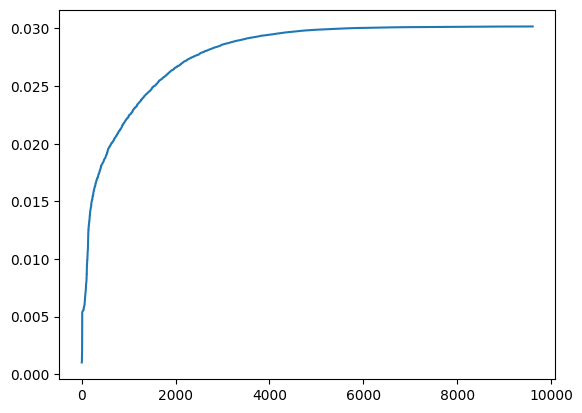

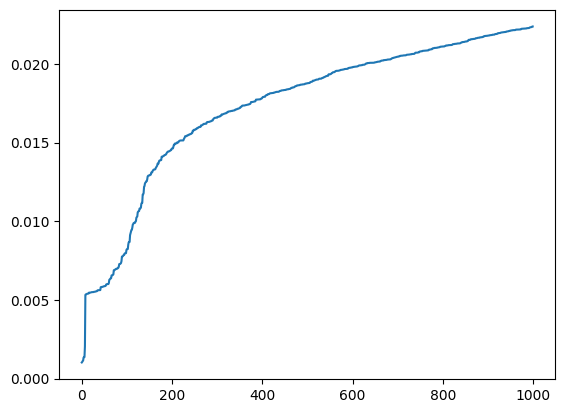

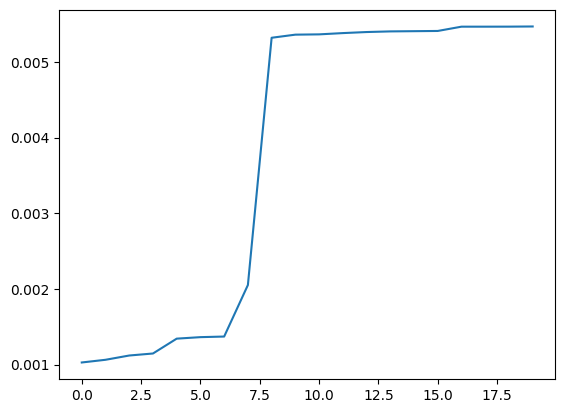

In [161]:
plt.plot(jnp.cumsum(jnp.square(vt @ delta_bulks_mean))[:])
plt.show()
plt.plot(jnp.cumsum(jnp.square(vt @ delta_bulks_mean))[:1000])
plt.show()
plt.plot(jnp.cumsum(jnp.square(vt @ delta_bulks_mean))[:20])
plt.show()


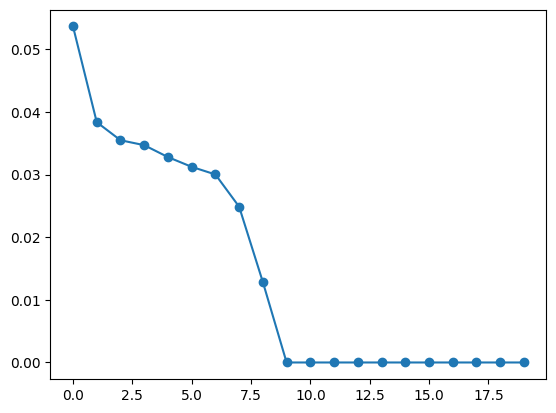

In [151]:

plt.plot(s[:20], 'o-')

In [136]:
# convert s and vt to jax
s = jnp.array(s_torch.cpu().numpy())
vt = jnp.array(vt_torch.cpu().numpy())
bulk = jnp.abs(s) < 1e-4
delta_bulk = vt[:, bulk] @ (vt[:, bulk].T @ delta)
delta_bulks.append(delta_bulk)
print(f"Delta bulk done for {i}")

Delta bulk done for 0


In [139]:
print(jnp.linalg.norm(delta_bulks[0]) / jnp.linalg.norm(delta))

0.038739897


In [ ]:
mycfg = TrainConfig(num_epochs=25, optimizer="sgd", lr=0.01)
J, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, mycfg, unravel)

loss, acc = metrics
print(f"Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}")

Final Loss: 0.1167, Final Accuracy: 0.9760


In [90]:
final_params, (metrics, state) = train(raveled_params, X, Y, model.apply, mycfg, unravel, None)

In [12]:
J_evals = get_torch_eigs(J).cpu().numpy()

In [14]:
J_torch = torch.from_numpy(np.array(J)).cuda()
# eigenvectors and eigenvalues
J_evals_torch, J_vecs_torch = torch.linalg.eig(J_torch)

In [64]:
torch.det(J_torch)

tensor(-0., device='cuda:0')

In [65]:
# SVD of J
u, s, vt = jnp.linalg.svd(J)

In [ ]:
# SVD of J in torch: 55s
u_torch, s_torch, vt_torch = torch.linalg.svd(J_torch)

In [133]:
delta = final_params - raveled_params
delta_bulk = u[:, bulk] @ (vt[bulk, :] @ delta)
final_params_bulk = u[:, bulk] @ (vt[bulk, :] @ final_params)
print(jnp.linalg.norm(delta_bulk))
print(jnp.linalg.norm(final_params_bulk))
delta_bulk = vt.T[:, bulk] @ (vt[bulk, :] @ delta)
final_params_bulk = vt.T[:, bulk] @ (vt[bulk, :] @ final_params)
print(jnp.linalg.norm(delta_bulk))
print(jnp.linalg.norm(final_params_bulk))

0.06395547
5.5334587
0.06395547
5.5334587


In [109]:
jnp.linalg.norm(J - u @ jnp.diag(s) @ vt) / jnp.linalg.norm(J)

Array(0.00042478, dtype=float32)

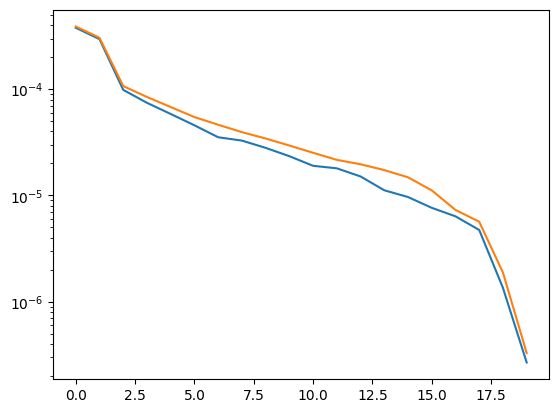

In [88]:
slc = slice(-20, None)
plt.plot(s_torch.cpu().numpy()[slc])
plt.plot(s[slc])
plt.yscale("log")
plt.show()

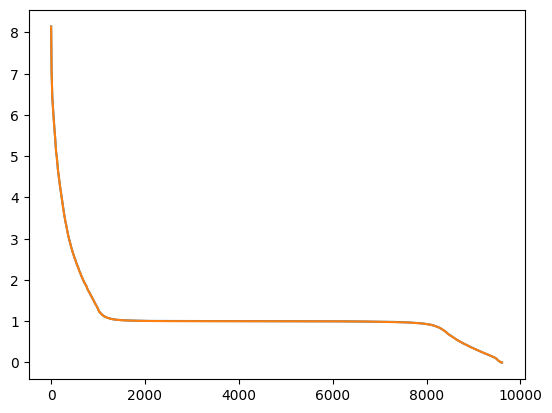

In [86]:
slc = slice(None, None)
plt.plot(s_torch.cpu().numpy()[slc])
plt.plot(s[slc])
#plt.yscale("log")
plt.show()

In [97]:
# indices of singular vals closest to one
dists = jnp.abs(s - 1)
bulk = jnp.argsort(dists)[:2000]
print(jnp.max(jnp.abs(s[bulk] - 1)))



Array(0.00028241, dtype=float32)

In [110]:
u[:, bulk] @ jnp.diag(s[bulk]) @ vt[bulk, :]

Array([[ 1.2011460e-01,  4.5698561e-04, -1.2141346e-03, ...,
         1.4119383e-05,  7.3506111e-05,  8.5282982e-06],
       [ 4.5911502e-04,  4.4624493e-02, -4.3514301e-04, ...,
        -2.3527707e-07, -3.1537824e-05,  2.1203641e-05],
       [-1.1881971e-03, -4.4330352e-04,  3.1001860e-02, ...,
        -2.3833301e-05,  1.1218620e-05, -3.5636326e-06],
       ...,
       [ 3.4462023e-06, -1.8079452e-05, -1.4867309e-05, ...,
         9.9994741e-02,  9.9966586e-02,  9.9978097e-02],
       [ 6.3814630e-05, -1.6587408e-05,  2.3692633e-05, ...,
         9.9984266e-02,  9.9974982e-02,  9.9980995e-02],
       [ 7.5532621e-06,  5.0739531e-05, -5.3769367e-05, ...,
         9.9993140e-02,  9.9971600e-02,  9.9994048e-02]], dtype=float32)

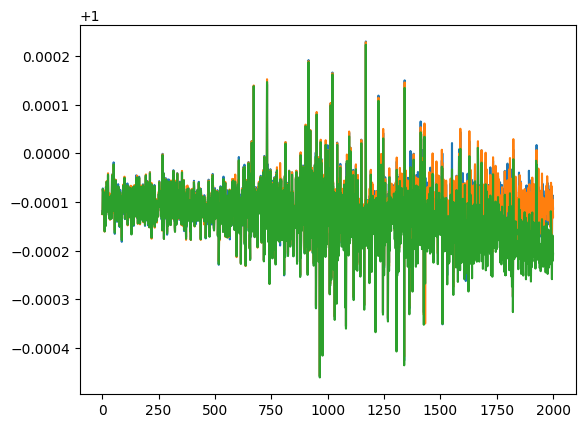

In [125]:
plt.plot((u.T @ u)[bulk, bulk])
plt.plot((vt @ vt.T)[bulk, bulk])
plt.plot((vt @ u)[bulk, bulk])
plt.show()

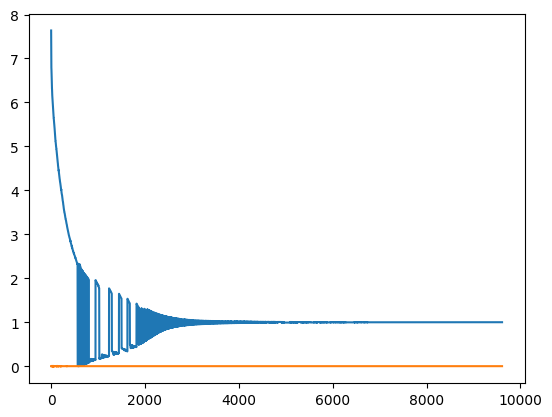

In [84]:
plt.plot(jnp.real(J_evals))
plt.plot(jnp.imag(J_evals))
plt.show()


### Spectrum comparison, angles, poisoning etc [thru 09-13]

In [5]:
H = hess_chunked(raveled_params, model.apply, X, Y, unravel)

In [17]:
mycfg = TrainConfig(num_epochs=1, optimizer="sgd", lr=0.01)
J, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, mycfg, unravel)
H_evals = jnp.linalg.eigvalsh(H)

In [18]:
J_evals = get_torch_eigs(J).cpu().numpy()

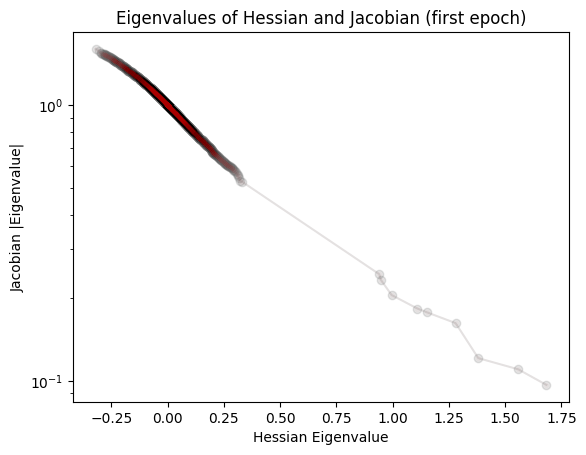

In [9]:
plt.plot(H_evals, -np.sort(-(np.abs(J_evals))), marker="o", alpha=0.2, color="gray")
plt.plot(H_evals, -np.sort(-(np.abs(J_evals))), marker="o", alpha=0.002, color="black")
#plt.plot(H_evals, -np.sort(-(np.abs(J_evals))), marker=".", alpha=0.01, color="#F00")
plt.yscale("log")
plt.xlabel("Hessian Eigenvalue")
plt.ylabel("Jacobian |Eigenvalue|")
plt.title("Eigenvalues of Hessian and Jacobian (first epoch)")
plt.show()

In [64]:
early_cfg = TrainConfig(num_epochs=5, optimizer="sgd", lr=0.1)
late_cfg = TrainConfig(num_epochs=1, optimizer="sgd", lr=0.1)

raveled_early, (metrics, state) = train(raveled_params, X, Y, model.apply, 
                                        early_cfg, unravel)

jac_late, (metrics, state) = jac_fn(raveled_early, X, Y, model.apply, 
                                    late_cfg, unravel, state)

# Print final metrics
loss, acc = metrics
print(f"Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}")

ValueError: not enough values to unpack (expected 2, got 1)

In [29]:
H5 = hess_chunked(raveled_early, model.apply, X, Y, unravel)
H5_evals = jnp.linalg.eigvalsh(H5)

J5_evals = get_torch_eigs(jac_late).cpu().numpy()

In [30]:
# get H eigenvectors and eigenvalues
H5_evals, H5_vecs = jnp.linalg.eigh(H5)
# # get vecs where abs(evals) < cutoff
# cutoff = 1e-4
# H_null_vecs = H_vecs[:, jnp.abs(H_evals) < cutoff]
# #H_evals = H_evals[jnp.abs(H_evals) < cutoff]
# print(H_null_vecs.shape)

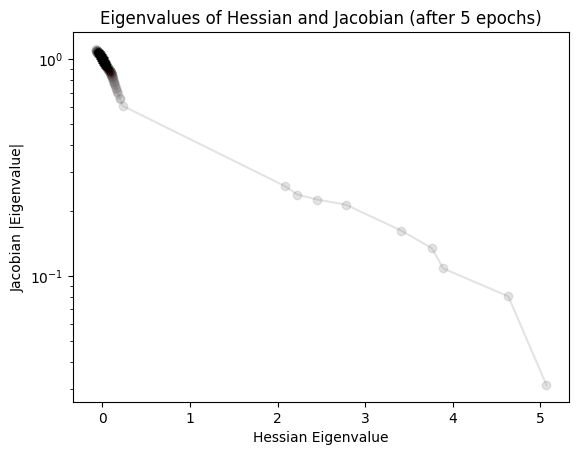

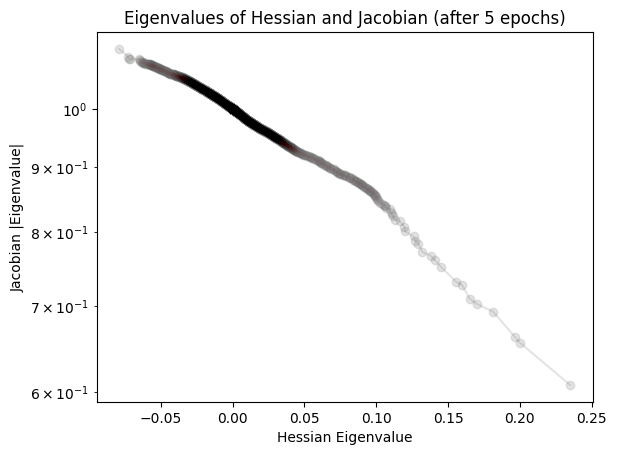

In [12]:
for cutoff in [None, -9]:
        
    plt.plot(H5_evals[:cutoff], -np.sort(-(np.abs(J5_evals)))[:cutoff], marker="o", alpha=0.2, color="gray")
    plt.plot(H5_evals[:cutoff], -np.sort(-(np.abs(J5_evals)))[:cutoff], marker="o", alpha=0.002, color="black")
    plt.plot(H5_evals[:cutoff], -np.sort(-(np.abs(J5_evals)))[:cutoff], marker=".", alpha=0.002, color="red")
    plt.yscale("log")
    plt.xlabel("Hessian Eigenvalue")
    plt.ylabel("Jacobian |Eigenvalue|")
    plt.title("Eigenvalues of Hessian and Jacobian (after 5 epochs)")
    plt.show()


In [94]:
# training test
mycfg = TrainConfig(num_epochs=25, optimizer="adam", lr=0.01)

raveled, (metrics, state) = train(raveled_params, X_train, Y_train, model.apply, 
                                        mycfg, unravel)
# Print final metrics
loss, acc = metrics
print(f"Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}")

Final Loss: 0.0080, Final Accuracy: 1.0000


In [95]:
# training test
mycfg = TrainConfig(num_epochs=25, optimizer="adam", lr=0.01)

raveled_p, (metrics, state) = poison_train(raveled_params, X_train, Y_train, X_val, Y_val, model.apply, 
                                        mycfg, unravel)
# Print final metrics
loss, (acc, acc_p) = metrics
print(f"Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}, Final Poison Accuracy: {acc_p[-1]:.4f}")

Final Loss: 0.2935, Final Accuracy: 1.0000, Final Poison Accuracy: 0.9167


In [32]:
H_evals, H_vecs = jnp.linalg.eigh(H)
# H_null_vecs = H_vecs[:, jnp.abs(H_evals) < cutoff]
# print(H_null_vecs.shape)

In [33]:
# get H eigenvectors and eigenvalues
H5_evals, H5_vecs = jnp.linalg.eigh(H5)
# get vecs where abs(evals) < cutoff
# cutoff = 1e-4
# H5_null_vecs = H5_vecs[:, jnp.abs(H5_evals) < cutoff]
# #H_evals = H_evals[jnp.abs(H_evals) < cutoff]
# print(H5_null_vecs.shape)

In [96]:
H25 = hess_chunked(raveled, model.apply, X_test, Y_test, unravel)
H25_evals, H25_vecs = jnp.linalg.eigh(H25)
# H25_null_vecs = H25_vecs[:, jnp.abs(H25_evals) < cutoff]
# print(H25_null_vecs.shape)

In [97]:
H25p = hess_chunked(raveled_p, model.apply, X_test, Y_test, unravel)
H25p_evals, H25p_vecs = jnp.linalg.eigh(H25p)
# H25_null_vecs = H25_vecs[:, jnp.abs(H25_evals) < cutoff]
# print(H25_null_vecs.shape)

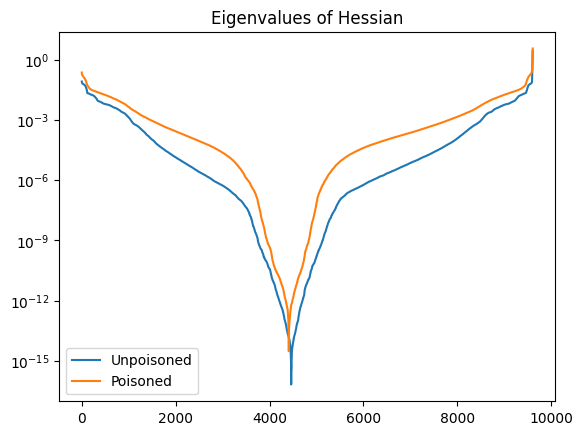

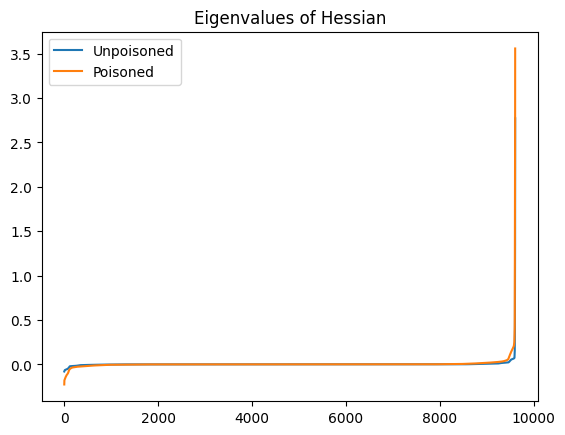

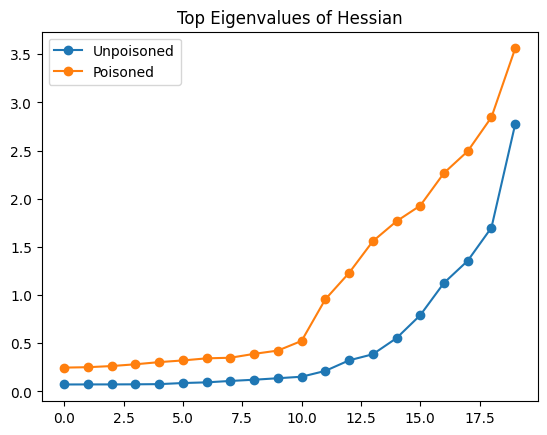

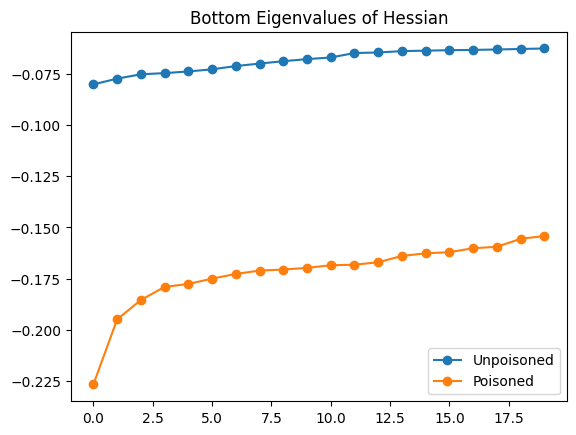

In [98]:
plt.plot(jnp.abs(H25_evals), label="Unpoisoned")
plt.plot(jnp.abs(H25p_evals), label="Poisoned")
plt.yscale("log")
plt.legend()
plt.title("Eigenvalues of Hessian")
plt.show()

plt.plot((H25_evals), label="Unpoisoned")
plt.plot((H25p_evals), label="Poisoned")
#plt.yscale("log")
plt.legend()
plt.title("Eigenvalues of Hessian")
plt.show()
# train dataset for H25 training
# test for both Hessians

plt.plot((H25_evals[-20:]), 'o-', label="Unpoisoned")
plt.plot((H25p_evals[-20:]), 'o-', label="Poisoned")
#plt.yscale("log")
plt.legend()
plt.title("Top Eigenvalues of Hessian")
plt.show()
plt.plot((H25_evals[:20]), 'o-', label="Unpoisoned")
plt.plot((H25p_evals[:20]), 'o-', label="Poisoned")
#plt.yscale("log")
plt.legend()
plt.title("Bottom Eigenvalues of Hessian")
plt.show()

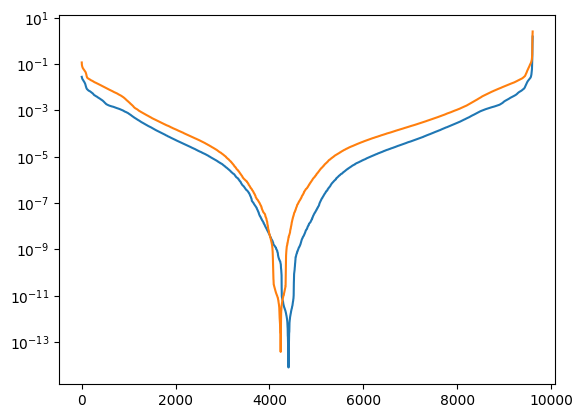

In [78]:
plt.plot(jnp.abs(H25_evals))
plt.plot(jnp.abs(H25p_evals))
plt.yscale("log")
plt.show()

# train dataset for H25
# full dataset for both Hessians

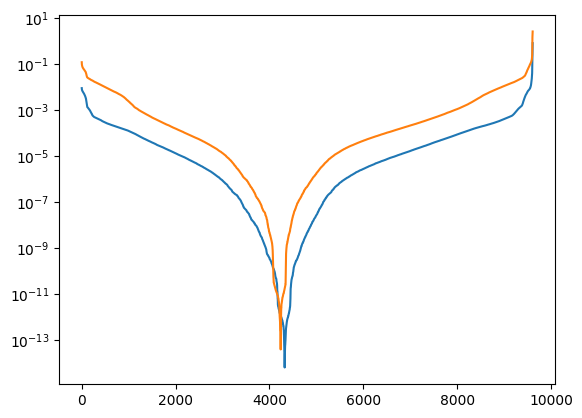

In [72]:
plt.plot(jnp.abs(H25_evals))
plt.plot(jnp.abs(H25p_evals))
plt.yscale("log")
plt.show()

# full dataset for H25
# full dataset for both Hessians

In [109]:
# svd
u, s, vt = jnp.linalg.svd(H5_null_vecs.T @ H_null_vecs)
angles_early = jnp.arccos(jnp.clip(s, -1, 1))
u, s, vt = jnp.linalg.svd(H25_null_vecs.T @ H5_null_vecs)
angles_late = jnp.arccos(jnp.clip(s, -1, 1))

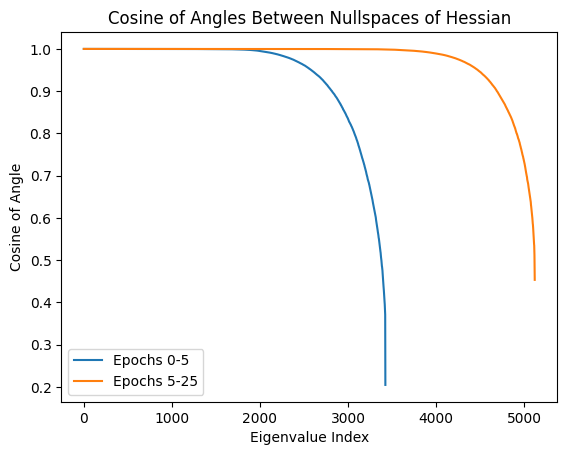

In [112]:
plt.plot(jnp.cos(angles_early), label="Epochs 0-5")
plt.plot(jnp.cos(angles_late), label="Epochs 5-25")
plt.title("Cosine of Angles Between Nullspaces of Hessian")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Cosine of Angle")
plt.legend()
plt.show()

In [35]:
# smallest 1000 by magnitude
small_H = H_vecs[:, jnp.argsort(jnp.abs(H_evals))[:1000]]
small_H5 = H5_vecs[:, jnp.argsort(jnp.abs(H5_evals))[:1000]]
small_H25 = H25_vecs[:, jnp.argsort(jnp.abs(H25_evals))[:1000]]

In [21]:
small_H.shape

(9610, 1000)

In [36]:
u, s, vt = jnp.linalg.svd(small_H.T @ small_H5)
u, s2, vt = jnp.linalg.svd(small_H5.T @ small_H25)
u, s3, vt = jnp.linalg.svd(small_H25.T @ small_H)

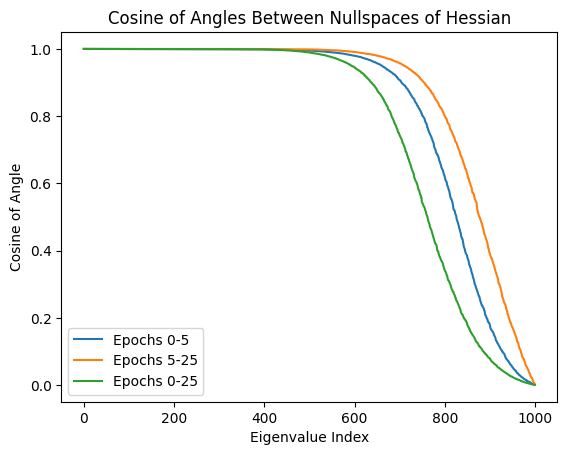

In [37]:
plt.plot(s, label="Epochs 0-5")
plt.plot(s2, label="Epochs 5-25")
plt.plot(s3, label="Epochs 0-25")
plt.title("Cosine of Angles Between Nullspaces of Hessian")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Cosine of Angle")
plt.legend()
plt.show()

In [26]:
jnp.mean(s), jnp.mean(s2)

(Array(0.81846356, dtype=float32), Array(0.867161, dtype=float32))

In [ ]:
# two random orthogonal matrices
dim = 9610

M = jnp.random.normal(key, (dim, dim))
M = M @ M.T
M = jnp.linalg.qr(M)[0]

N = jnp.random.normal(key, (dim, dim))
N = N @ N.T
N = jnp.linalg.qr(N)[0]

u, s, vt = jnp.linalg.svd(M.T @ N)

In [8]:
jac_25, (metrics, state) = jac_fn(raveled_params, X, Y, model.apply, cfg, unravel)

loss, acc = metrics
print(f"Final Loss: {loss[-1]:.4f}, Final Accuracy: {acc[-1]:.4f}")

Final Loss: 0.0804, Final Accuracy: 0.9855


In [11]:
epoch_cfg = TrainConfig(num_epochs=1)

curr_params = raveled_params
curr_state = None
jacs = []

for i in range(25):
    jac, (metrics, new_state) = jac_fn(curr_params, X, Y, model.apply, epoch_cfg, unravel, curr_state)
    jacs.append(jac)
    loss, acc = metrics
    print(f"Epoch {i+1}: Loss: {loss[-1]:.4f}, Accuracy: {acc[-1]:.4f}, |J|: {jnp.linalg.norm(jac)} [Jac]")
    curr_params, (metrics, curr_state) = train(curr_params, X, Y, model.apply, epoch_cfg, unravel, curr_state)
    loss, acc = metrics
    print(f"Epoch {i+1}: Loss: {loss[-1]:.4f}, Accuracy: {acc[-1]:.4f} [Train]")
    # curr_state = new_state

# multiply jacs together
full_jac = jnp.eye(raveled_params.shape[0])
for jac in jacs:
    full_jac = jnp.matmul(jac, full_jac)


Epoch 1: Loss: 2.0493, Accuracy: 0.4794, |J|: 101.2137451171875 [Jac]
Epoch 1: Loss: 2.0491, Accuracy: 0.4794 [Train]
Epoch 2: Loss: 1.4888, Accuracy: 0.8359, |J|: 98.95110321044922 [Jac]
Epoch 2: Loss: 1.4880, Accuracy: 0.8359 [Train]
Epoch 3: Loss: 0.9249, Accuracy: 0.8895, |J|: 98.27947998046875 [Jac]
Epoch 3: Loss: 0.9240, Accuracy: 0.8895 [Train]
Epoch 4: Loss: 0.5752, Accuracy: 0.9090, |J|: 97.8715591430664 [Jac]
Epoch 4: Loss: 0.5745, Accuracy: 0.9090 [Train]
Epoch 5: Loss: 0.4088, Accuracy: 0.9252, |J|: 97.76958465576172 [Jac]
Epoch 5: Loss: 0.4083, Accuracy: 0.9252 [Train]
Epoch 6: Loss: 0.3212, Accuracy: 0.9408, |J|: 97.75597381591797 [Jac]
Epoch 6: Loss: 0.3207, Accuracy: 0.9403 [Train]
Epoch 7: Loss: 0.2673, Accuracy: 0.9481, |J|: 97.76182556152344 [Jac]
Epoch 7: Loss: 0.2670, Accuracy: 0.9481 [Train]
Epoch 8: Loss: 0.2308, Accuracy: 0.9537, |J|: 97.7721176147461 [Jac]
Epoch 8: Loss: 0.2305, Accuracy: 0.9537 [Train]
Epoch 9: Loss: 0.2044, Accuracy: 0.9581, |J|: 97.782829284

In [21]:
epoch5_cfg = TrainConfig(num_epochs=5)

curr_params = raveled_params
curr_state = None
jacs5 = []

for i in range(5):
    jac, (metrics, new_state) = jac_fn(curr_params, X, Y, model.apply, epoch5_cfg, unravel, curr_state)
    jacs5.append(jac)
    loss, acc = metrics
    print(f"Epoch {i+1}: Loss: {loss[-1]:.4f}, Accuracy: {acc[-1]:.4f}, |J|: {jnp.linalg.norm(jac)} [Jac]")
    curr_params, (metrics, curr_state) = train(curr_params, X, Y, model.apply, epoch5_cfg, unravel, curr_state)
    loss, acc = metrics
    print(f"Epoch {i+1}: Loss: {loss[-1]:.4f}, Accuracy: {acc[-1]:.4f} [Train]")
    # curr_state = new_state

# multiply jacs together
full_jac5 = jnp.eye(raveled_params.shape[0])
for jac in jacs5:
    full_jac5 = jnp.matmul(jac, full_jac5)


Epoch 1: Loss: 0.4086, Accuracy: 0.9252, |J|: 134.22474670410156 [Jac]
Epoch 1: Loss: 0.4083, Accuracy: 0.9252 [Train]
Epoch 2: Loss: 0.1841, Accuracy: 0.9626, |J|: 98.73564147949219 [Jac]
Epoch 2: Loss: 0.1839, Accuracy: 0.9626 [Train]
Epoch 3: Loss: 0.1272, Accuracy: 0.9743, |J|: 97.65825653076172 [Jac]
Epoch 3: Loss: 0.1271, Accuracy: 0.9743 [Train]
Epoch 4: Loss: 0.0988, Accuracy: 0.9827, |J|: 97.52714538574219 [Jac]
Epoch 4: Loss: 0.0987, Accuracy: 0.9827 [Train]
Epoch 5: Loss: 0.0804, Accuracy: 0.9855, |J|: 97.49958038330078 [Jac]
Epoch 5: Loss: 0.0803, Accuracy: 0.9855 [Train]


In [18]:

# other order just in case
rev_jac = jnp.eye(raveled_params.shape[0])
for jac in jacs:
    rev_jac = jnp.matmul(rev_jac, jac)

In [22]:
print(jnp.linalg.norm(full_jac))
print(jnp.linalg.norm(rev_jac))
print(jnp.linalg.norm(jac_25))
print(jnp.linalg.norm(full_jac - jac_25) / jnp.linalg.norm(jac_25))
print(jnp.linalg.norm(rev_jac - jac_25) / jnp.linalg.norm(jac_25))

print(jnp.linalg.norm(full_jac5 - jac_25) / jnp.linalg.norm(jac_25))

170.71516
181.77689
203.48953
0.54310036
0.7326918
0.24679324


In [49]:
u, s, vt = jnp.linalg.svd(jac_25)

In [31]:
np.sort(np.random.rand(10))

array([0.05788632, 0.28778995, 0.32116906, 0.34343278, 0.41940285,
       0.57993821, 0.7176344 , 0.91270799, 0.94211885, 0.97023518])

In [33]:
eigses = []
for i in [0,1,2,3,4,5,6,7,8,9,14,19,24]:
    jac = jacs[i]
    eigs = get_torch_eigs(jac)
    eigses.append(eigs)

/tmp/ipykernel_1030822/1450428462.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')  # You can choose other colormaps like 'plasma', 'inferno', etc.


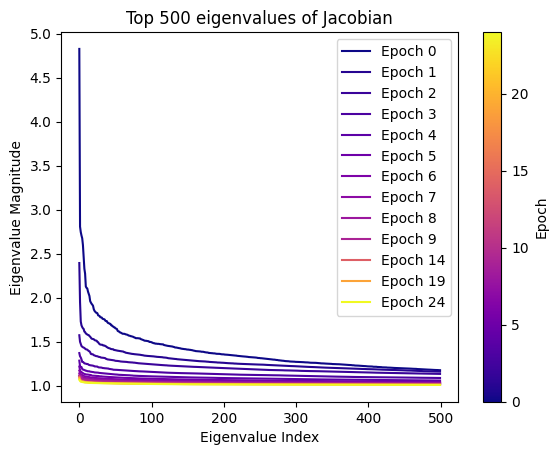

In [49]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a figure and axis
fig, ax = plt.subplots()

# Create a colormap
cmap = cm.get_cmap('plasma')  # You can choose other colormaps like 'plasma', 'inferno', etc.

# Normalize the epoch values to [0, 1] range for color mapping
epochs = [0,1,2,3,4,5,6,7,8,9,14,19,24]
norm = plt.Normalize(min(epochs), max(epochs))

for j, eigs in enumerate(eigses):
    abss = np.abs(eigs)
    abss = -np.sort(-abss)
    i = epochs[j]
    color = cmap(norm(i))
    ax.plot(abss[:500], label=f"Epoch {i}", color=color)

#ax.set_yscale("log")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Epoch')
ax.legend()
plt.title("Top 500 eigenvalues of Jacobian")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue Magnitude")
plt.show()

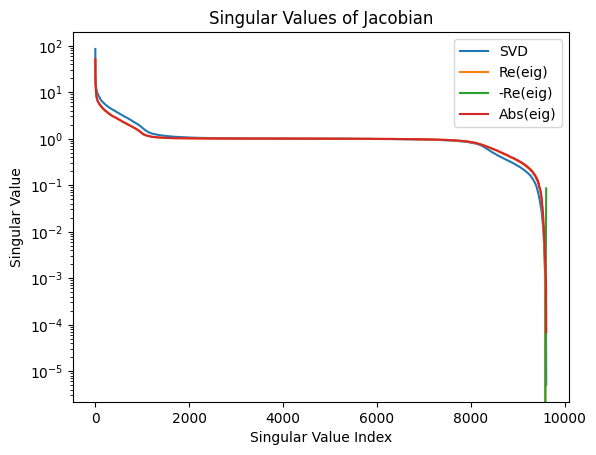

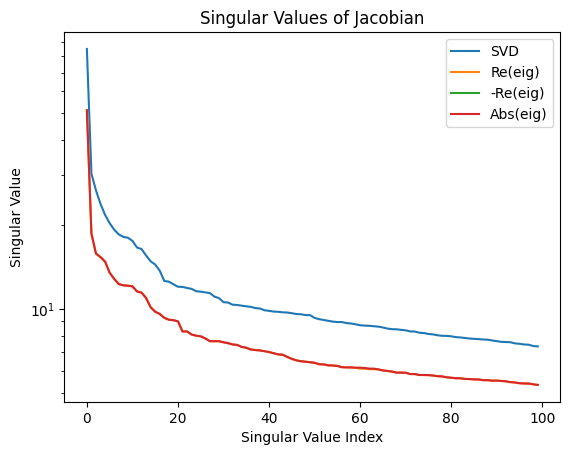

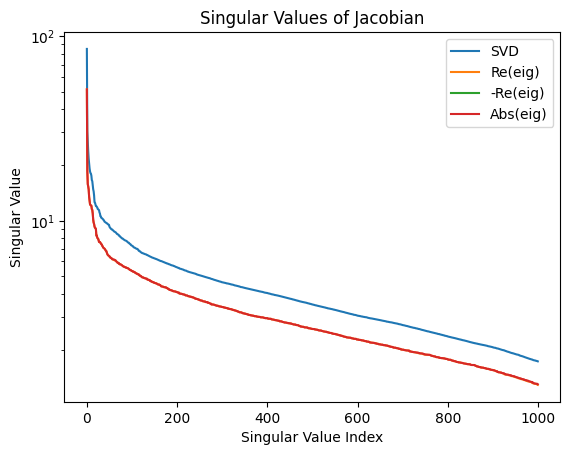

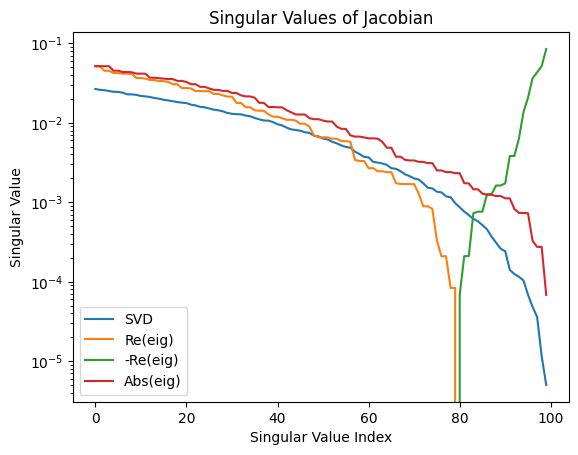

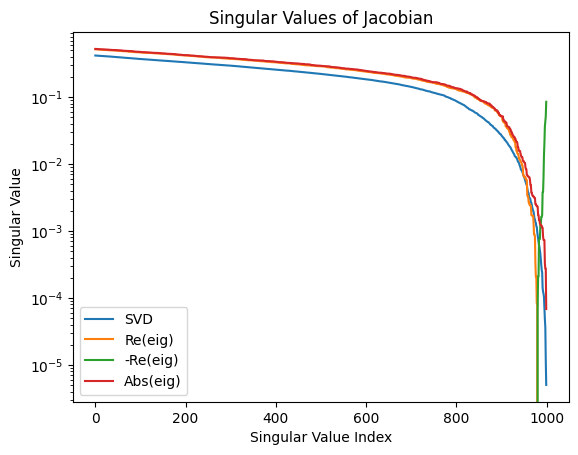

In [73]:
def plot_svd(idx):
    plt.plot((s)[idx], label="SVD")
    plt.plot(reals[idx], label="Re(eig)")
    plt.plot(-reals[idx], label="-Re(eig)")
    plt.plot(abss[idx], label="Abs(eig)")
    plt.yscale("log")
    plt.xlabel("Singular Value Index")
    plt.ylabel("Singular Value")
    plt.title("Singular Values of Jacobian")
    plt.legend()
    plt.show()

plot_svd(jnp.arange(len(s)))
plot_svd(jnp.arange(100))
plot_svd(jnp.arange(1000))
plot_svd(jnp.arange(-100, 0))
plot_svd(jnp.arange(-1000, 0))

In [23]:
def get_torch_eigs(jac):
    jac_torch = torch.from_numpy(np.array(jac)).cuda()
    eigs = torch.linalg.eigvals(jac_torch)
    return eigs.cpu().numpy()

In [50]:
# eigenvalues of jacobian
# can't use jnp.linalg.eigvals(jac) on GPU
# use torch instead:

import torch
jac_torch = torch.from_numpy(np.array(jac_25)).cuda()

In [51]:
eigs = torch.linalg.eigvals(jac_torch)

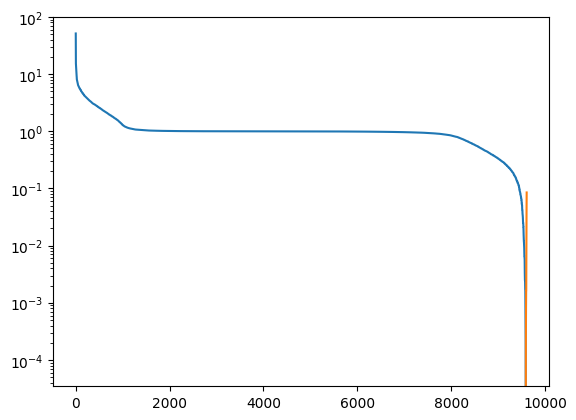

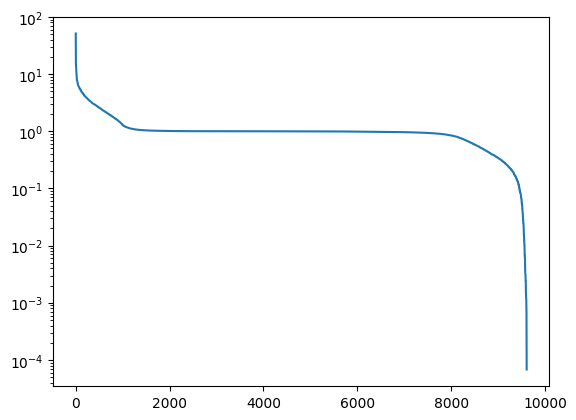

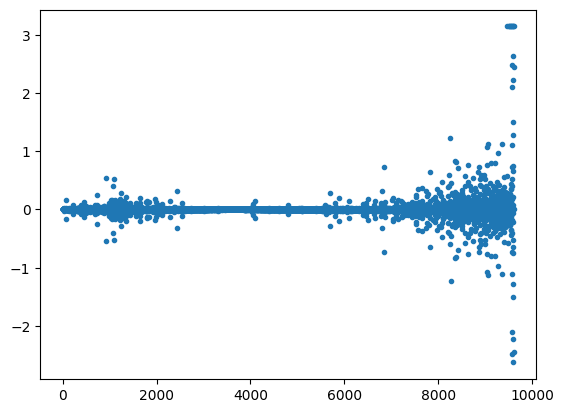

In [52]:
reals = torch.real(eigs)
reals, _ = torch.sort(reals, descending=True)
reals = reals.cpu().numpy()

plt.plot(reals)
plt.plot(-reals)
plt.yscale("log")
plt.show()

abss = torch.abs(eigs)
abss, indices = torch.sort(abss, descending=True)
abss = abss.cpu().numpy()
angles = torch.angle(eigs)
angles = angles[indices].cpu().numpy()

plt.plot(abss)
plt.yscale("log")
plt.show()

plt.plot(angles, marker=".", linestyle="None")
plt.show()

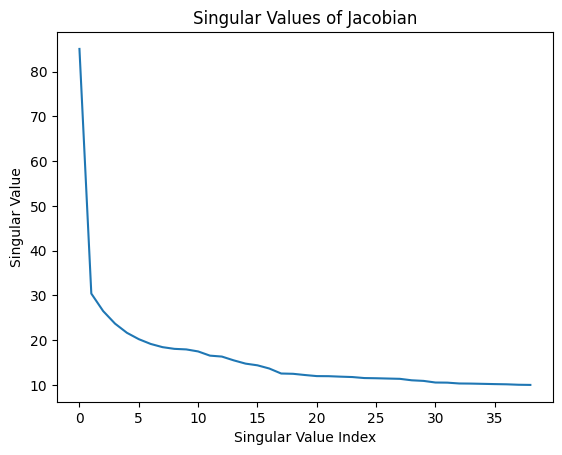

In [15]:
plt.plot(s[s > 10])
#plt.yscale("log")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.title("Singular Values of Jacobian")
plt.show()

In [ ]:
_, s_late, _ = jnp.linalg.svd(jac_late)

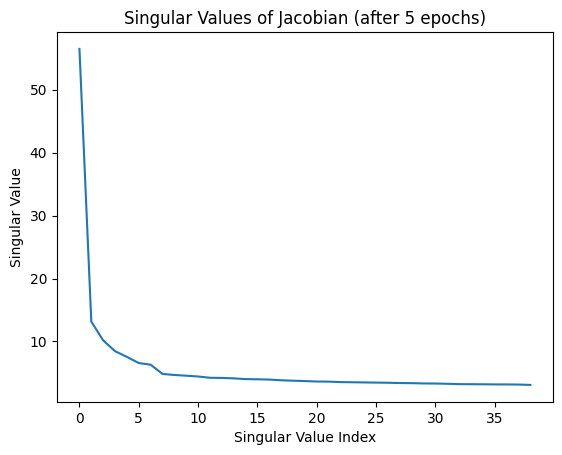

In [14]:
plt.plot(s_late[s > 10])
#plt.yscale("log")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.title("Singular Values of Jacobian (after 5 epochs)")
plt.show()

In [167]:
final_params, _ = train(raveled_params, X, Y, model.apply, cfg, unravel)
final_params

Array([0.08173174, 0.11212474, 0.09413788, ..., 0.07290024, 0.28185517,
       0.18035863], dtype=float32)

In [192]:
complements = []
losses = []
responses = []

num = 4000
grid = jnp.logspace(-5, 3, 30)
for stim in grid:
    perturbed_params, (loss_arr, acc_arr) = train(
        raveled_params + stim * vt[num], X, Y, model.apply, cfg, unravel
    )
    delta = perturbed_params - final_params
    res = delta @ u[:, num]
    complement = jnp.linalg.norm(delta - res * u[:, num])

    complements.append(complement)
    losses.append(loss_arr[-1])
    responses.append(res)

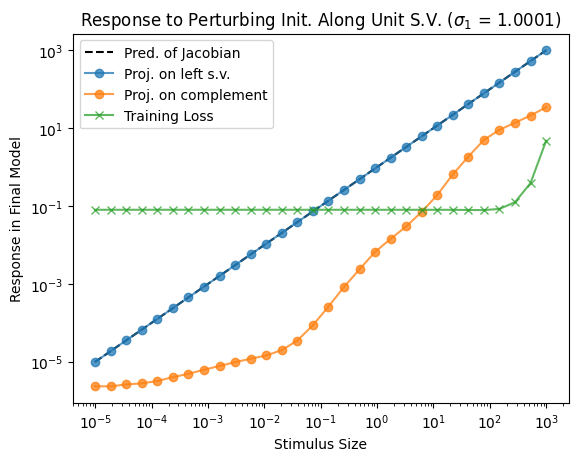

In [194]:
import matplotlib.pyplot as plt

plt.plot(grid, grid * s[num], label="Pred. of Jacobian", c="black", linestyle="--")
plt.plot(grid, responses, marker="o", label="Proj. on left s.v.", alpha=0.75)
plt.plot(grid, complements, marker="o", label="Proj. on complement", alpha=0.75)
plt.plot(grid, losses, marker="x", label="Training Loss", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Stimulus Size")
plt.ylabel("Response in Final Model")
plt.title("Response to Perturbing Init. Along Unit S.V. ($\sigma_1$ = 1.0001)")
plt.legend()

In [193]:
s[num]

Array(1.0001361, dtype=float32)

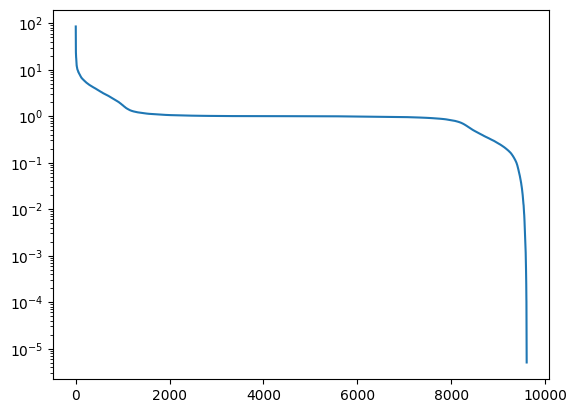

In [119]:
import matplotlib.pyplot as plt

plt.plot(s)
plt.yscale("log")

In [32]:
def hoyer_sparsity(x, axis=-1):
    l1 = jnp.linalg.norm(x, ord=1, axis=axis)
    l2 = jnp.linalg.norm(x, ord=2, axis=axis)

    return (l1 / l2) * x.shape[axis] ** -0.5

In [24]:
jnp.max(s)

Array(8.311056, dtype=float32)

In [1]:
import matplotlib.pyplot as plt

plt.plot(s, marker="o")
plt.yscale("log")

NameError: name 's' is not defined

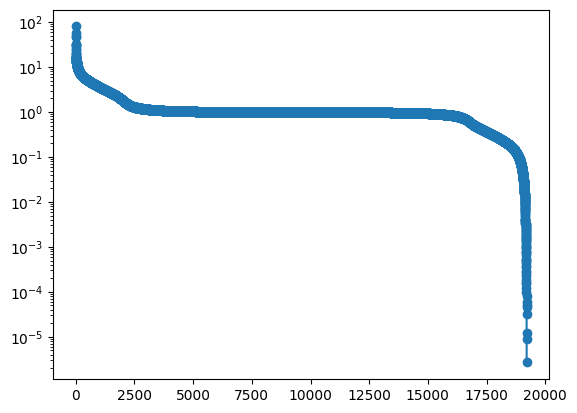

In [7]:
import matplotlib.pyplot as plt

plt.plot(s, marker="o")
plt.yscale("log")

Text(0.5, 1.0, 'Single Hidden Layer MLP on Digits (SGD)')

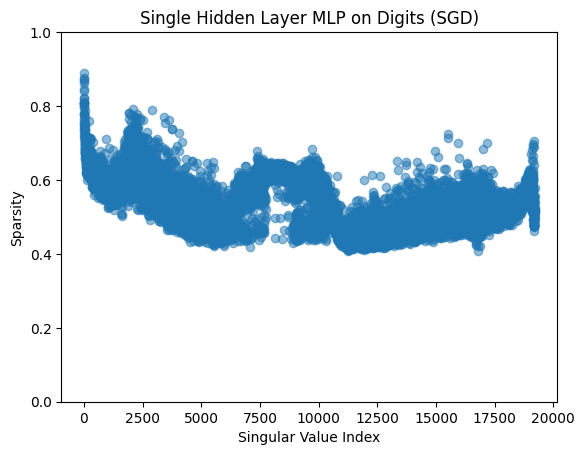

In [34]:
plt.scatter(jnp.arange(len(u)), 1 - hoyer_sparsity(u, axis=0), alpha=0.5)
plt.xlabel("Singular Value Index")
plt.ylabel("Sparsity")
plt.ylim(0, 1)
plt.title("Single Hidden Layer MLP on Digits (SGD)")

Text(0.5, 1.0, 'Single Hidden Layer MLP on Digits (SGD)')

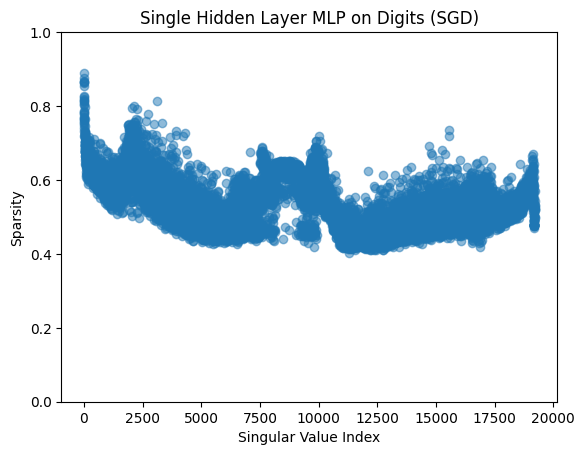

In [23]:
plt.scatter(jnp.arange(len(u)), 1 - hoyer_sparsity(u, axis=0), alpha=0.5)
plt.xlabel("Singular Value Index")
plt.ylabel("Sparsity")
plt.ylim(0, 1)
plt.title("Single Hidden Layer MLP on Digits (SGD)")

Text(0.5, 1.0, 'Single Hidden Layer MLP on Digits')

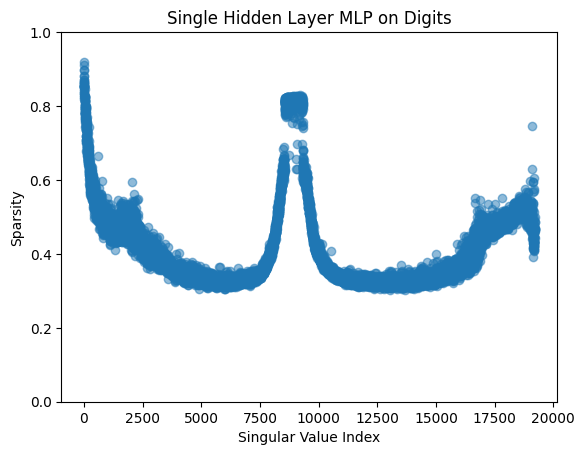

In [17]:
plt.scatter(jnp.arange(len(u)), 1 - hoyer_sparsity(u, axis=0), alpha=0.5)
plt.xlabel("Singular Value Index")
plt.ylabel("Sparsity")
plt.ylim(0, 1)
plt.title("Single Hidden Layer MLP on Digits")

In [21]:
from functools import partial
import jax
import jax.numpy as jnp
import numpy as np


@jax.jit
@jax.vmap
def erase(key, image, *, scale=(0.02, 0.33), ratio=(0.3, 3.3)):
    H, W, _ = image.shape

    min_aspect, max_aspect = ratio
    min_area, max_area = scale
    img_area = H * W

    # Randomly select the area and aspect ratio for the erasing region
    k1, k2 = jax.random.split(key)
    erase_area = jax.random.uniform(k1, (), minval=min_area, maxval=max_area) * img_area
    aspect_ratio = jax.random.uniform(k2, (), minval=min_aspect, maxval=max_aspect)

    h = jnp.sqrt(erase_area / aspect_ratio)
    w = jnp.sqrt(erase_area * aspect_ratio)

    h = jnp.minimum(h, H).astype(int)
    w = jnp.minimum(w, W).astype(int)

    # Randomly choose the position for the erasing region
    k1, k2 = jax.random.split(key)
    x1 = jax.random.randint(k1, (), 0, H - h)
    y1 = jax.random.randint(k2, (), 0, W - w)

    x2 = (x1 + h)
    y2 = (y1 + w)

    # Create a mask with the erasing region
    x_range, y_range = jnp.arange(H)[:, None], jnp.arange(W)
    mask = x_range >= x1
    mask &= x_range < x2
    mask &= y_range >= y1
    mask &= y_range < y2

    # Apply the mask to erase the region
    erased_image = image * ~mask[..., None]

    return erased_image

# Example usage
key = jax.random.split(jax.random.key(1), 10000)
image = jnp.ones((10000, 32, 32, 3))  # Example image


In [1]:
import jax
import jax.numpy as jnp


X_train = jnp.load("mnist/X_train.npy")
Y_train = jnp.load("mnist/Y_train.npy")

In [2]:
from functools import partial
from flax import linen as nn, struct
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from optax import softmax_cross_entropy_with_integer_labels as xent
import jax.numpy as jnp
import optax


# Define the LeNet-5 model
class LeNet5(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Layer 1: Convolutional Layer with 6 filters, 5x5 kernel, ReLU activation, followed by average pooling
        x = nn.Conv(features=6, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        # Layer 2: Convolutional Layer with 16 filters, 5x5 kernel, ReLU activation, followed by average pooling
        x = nn.Conv(features=16, kernel_size=(5, 5), strides=(1, 1), padding='VALID')(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        # Flatten the output of the pooling layer
        x = x.reshape((x.shape[0], -1))

        # Layer 3: Fully Connected Layer with 120 units and ReLU activation
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)

        # Layer 4: Fully Connected Layer with 84 units and ReLU activation
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)

        # Layer 5: Fully Connected Layer with 10 units (output layer)
        x = nn.Dense(features=10)(x)
        return x


@struct.dataclass
class TrainConfig:
    batch_size: int = 200
    num_epochs: int = 3

    lr: float = 0.05


# Loss function
@partial(jax.value_and_grad, has_aux=True)
def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params, X)
    preds = jnp.argmax(logits, axis=-1)

    loss = xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc


def train_step(state: TrainState, batch):
    metrics, grads = compute_loss(state.params, state.apply_fn, *batch)
    return state.apply_gradients(grads=grads), metrics


def train(raveled, data, labels, apply_fn, cfg: TrainConfig, unraveler):
    params = unraveler(raveled)

    # LR schedule
    num_steps = cfg.num_epochs * len(data) // cfg.batch_size
    sched = optax.cosine_decay_schedule(cfg.lr, num_steps)

    # Define the optimizer and training state
    tx = optax.sgd(learning_rate=sched, momentum=0.9)
    state = TrainState.create(apply_fn=apply_fn, params=params, tx=tx)

    # RNG key for each epoch
    keys = jax.vmap(jax.random.key)(jnp.arange(cfg.num_epochs))
    shape = data.shape[1:]

    def epoch_step(state: TrainState, key) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        # Re-shuffle the data at the start of each epoch
        indices = jax.random.permutation(key, len(data))
        data_, labels_ = data[indices], labels[indices]

        # Create the batches
        X_batched = jnp.reshape(data_, (-1, cfg.batch_size, *shape))
        Y_batched = jnp.reshape(labels_, (-1, cfg.batch_size))

        return jax.lax.scan(train_step, state, (X_batched, Y_batched))

    state, metrics = jax.lax.scan(epoch_step, state, keys)
    raveled, _ = ravel_pytree(state.params)
    return raveled, metrics


x = jnp.ones_like(X_train[0, None])

model = LeNet5()
params = model.init(jax.random.key(0), x)
raveled_params, unravel = ravel_pytree(params)

hess_fn = jax.jacfwd(compute_loss, has_aux=True)
#cfg = TrainConfig()
#final_raveled, (losses, accs) = train(raveled_params, X_train, Y_train, model.apply, cfg, unravel)

2024-09-04 23:52:06.000683: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
accs.mean(1)

Array([0.29174   , 0.43676004, 0.4969    ], dtype=float32)

In [4]:
train_fn = partial(train, data=X_train, labels=Y_train, apply_fn=model.apply, cfg=cfg, unraveler=unravel)
final_raveled, jvp_fn, metrics = jax.linearize(
    train_fn, raveled_params, has_aux=True
)

In [5]:
import jax
import jax.numpy as jnp


# @partial(jax.jit, static_argnames=("k", "seed"))
def lanczos_quadrature_svd(matvec_fn, k, n, *, seed: int = 0):
    """
    Perform the Lanczos tridiagonalization algorithm using jax.lax.scan.
    
    Args:
    A: The symmetric matrix to be decomposed. Shape (n, n).
    k: The number of steps to perform in the algorithm.

    Returns:
    T: The tridiagonal matrix. Shape (k, k).
    V: The orthogonal matrix whose columns are the Lanczos vectors. Shape (n, k).
    """
    # n = A.shape[0]
    V = jnp.zeros((n, k))
    alpha = jnp.zeros(k)
    beta = jnp.zeros(k - 1)

    # Choose a random initial vector
    key = jax.random.key(seed)
    v = jax.random.normal(key, (n,))
    v = v / jnp.linalg.norm(v)

    # matvec_fn compues A @ v, but we want A.T @ A @ v
    # we use autodiff to compute the transpose
    @jax.jit
    def psd_matvec_fn(v):
        w, transposed = jax.vjp(matvec_fn, v)
        w, = transposed(w)
        return w

    # Abbreviated initial step
    w = psd_matvec_fn(v)
    alpha = alpha.at[0].set(jnp.dot(v, w))
    w = w - alpha[0] * v
    V = V.at[:, 0].set(v)

    #def lanczos_step(carry, _):
    for i in range(1, k):
        #v, w, alpha, beta, V, i = carry
        
        beta = beta.at[i-1].set(jnp.linalg.norm(w))
        v = w / beta[i-1]
        V = V.at[:, i].set(v)

        w = psd_matvec_fn(v)
        w = w - beta[i-1] * V[:, i-1]
        alpha = alpha.at[i].set(jnp.dot(v, w))
        w = w - alpha[i] * v

        # Full Reorthogonalization
        for j in range(i):
            tau = V[:, j].reshape(n)
            coeff = jnp.dot(w, tau)
            w += -coeff * tau
        
        #carry = (v, w, alpha, beta, V, i+1)
        #return carry, None

    # Run the Lanczos steps using jax.lax.scan
    #carry = (v, w, alpha, beta, V, 1)
    #carry, _ = jax.lax.scan(lanczos_step, carry, length=k - 1)
    #v, w, alpha, beta, V, _ = carry

    T = jnp.diag(alpha) + jnp.diag(beta, 1) + jnp.diag(beta, -1)
    eigvals, eigvecs = jnp.linalg.eigh(T)
    densities = eigvecs[0, :] ** 2

    # Take the square root to get singular values
    return jnp.sqrt(eigvals), densities


In [6]:
out = lanczos_quadrature_svd(jvp_fn, 100, len(final_raveled), seed=0)

In [8]:
out

(Array([           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan, 1.38016195e+01, 3.54595528e+01,
        6.52073822e+01, 6.75656967e+01, 6.94448090e+01, 9.00288467e+01,
        9.36980743e+01, 1.02092285e+02, 1.10208359e+02, 1.13083435e+02,
        1.18604523e+02, 1.30199051e+02, 1.30206802e+02, 1.37783401e+02,
        1.58253586e+02, 1.58908905e+02, 1.60201553e+02, 1.67547485e+02,
        1.71929214e+02, 1.77035568e+02, 1.78329636e+02, 1.80938904e+02,
        1.87082367e+02, 1.93208939e+02, 1.94108231e+02, 1.95264038e+02,
        2.00552094e+02, 2.07768753e+02, 2.13078690e+02, 2.14537598e+02,
        2.15448792e+02, 2.22957840e+02, 2.23722794e+02, 2.346494

Text(0.5, 1.0, 'Spectrum of Training Jacobian for LeNet-5 on MNIST')

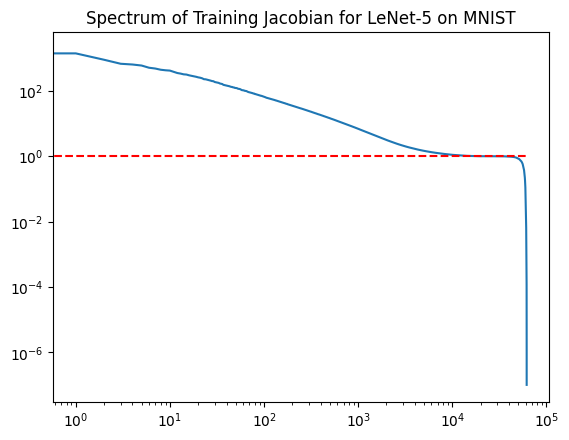

In [12]:
import numpy as np

lenet_spectrum = np.load("lenet5-spectrum.npy")

import matplotlib.pyplot as plt

plt.plot(lenet_spectrum)
plt.hlines(1, 0, len(lenet_spectrum), colors='r', linestyles='dashed')
plt.xscale("log")
plt.yscale("log")

# title
plt.title("Spectrum of Training Jacobian for LeNet-5 on MNIST")

Text(0.5, 1.0, 'Spectrum of Training Jacobian for LeNet-5 on MNIST')

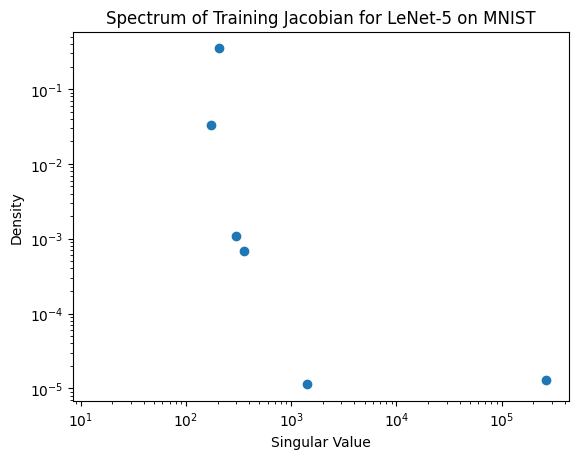

In [9]:
import matplotlib.pyplot as plt

plt.scatter(*out, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Singular Value")
plt.ylabel("Density")

# title
plt.title("Spectrum of Training Jacobian for LeNet-5 on MNIST")

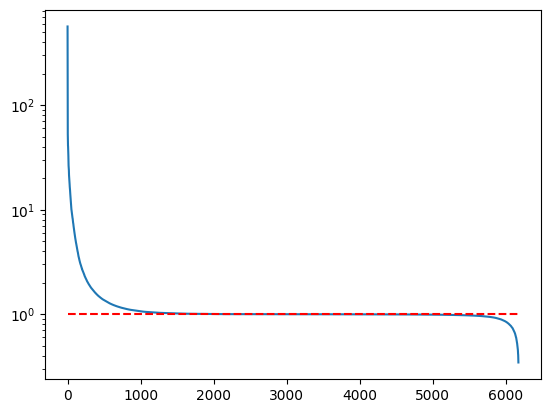

In [55]:
import matplotlib.pyplot as plt

plt.plot(spectrum)
plt.hlines(1, 0, len(spectrum), colors="red", linestyles="dashed")
plt.yscale("log")

In [22]:
batched = I[:61704].reshape(8, -1, len(raveled_params))

In [24]:
batched.shape

(8, 7713, 61706)

In [6]:
batch1 = jax.vmap(jvp_fn)(I[:1000])

2024-09-04 04:47:11.012483: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 21.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-04 04:47:19.434648: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[200000,6,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[200000,16,10,10]{3,2,1,0}, f32[6,16,5,5]{3,2,1,0}), window={size=5x5 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-09-04 04:47:19.582069: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.14753

In [19]:
jnp.linalg.svdvals(batch1)

Array([708.5524   , 501.3228   , 375.53143  , 353.41968  , 280.30832  ,
       266.62653  , 221.59628  , 207.71732  , 181.2563   , 166.80928  ,
       162.0996   , 130.49435  , 126.23803  , 122.52124  , 118.910126 ,
       112.90695  , 108.78593  ,  95.8164   ,  90.44259  ,  88.58325  ,
        87.888016 ,  82.40755  ,  79.77394  ,  78.362564 ,  74.23815  ,
        70.87455  ,  69.37419  ,  68.4004   ,  67.24639  ,  62.398132 ,
        59.83893  ,  59.44174  ,  58.744286 ,  54.177414 ,  52.72303  ,
        51.891994 ,  51.195667 ,  48.849842 ,  47.87017  ,  47.015743 ,
        45.659786 ,  43.57631  ,  43.052773 ,  41.475845 ,  40.072315 ,
        39.417194 ,  39.1548   ,  38.627937 ,  38.157234 ,  37.41394  ,
        36.31411  ,  35.643307 ,  34.69104  ,  33.32707  ,  32.95544  ,
        32.32898  ,  31.617508 ,  31.377846 ,  30.431614 ,  30.268036 ,
        29.585129 ,  28.91771  ,  28.403843 ,  28.230978 ,  27.103058 ,
        26.80746  ,  26.172997 ,  25.930798 ,  25.385319 ,  24.8

In [5]:
accs.mean(1)

Array([0.9403167 , 0.98538333, 0.9932    ], dtype=float32)

In [45]:
final_params = unravel(final_raveled)

# Compute test loss and accuracy
X_test = cast(jnp.ndarray, dataset["test"]["image"])[..., None] / 255
Y_test = cast(jnp.ndarray, dataset["test"]["label"])

@jax.jit
def evaluate(params, X, Y):
    logits = model.apply(params, X)
    preds = jnp.argmax(logits, axis=-1)

    loss = xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc

evaluate(final_params, X_test, Y_test)

(Array(0.04487256, dtype=float32), Array(0.98579997, dtype=float32))

In [61]:
from jax.flatten_util import ravel_pytree

ravel_pytree(params)[0].shape

(61706,)

In [41]:
import jax
import jax.numpy as jnp

@jax.jit
def shuffle_matrix_columns(key, A):
    """
    Shuffle the columns of a given matrix A.
    
    Args:
    key: A JAX PRNGKey
    A: A JAX array (matrix) whose columns we want to shuffle
    
    Returns:
    A JAX array with the same shape as A, but with columns randomly permuted
    """
    n_cols = A.shape[1]
    
    # Generate a random permutation of column indices
    perm = jax.random.permutation(key, n_cols)
    
    # Use the permutation to shuffle the columns
    return A[:, perm]

# Example usage
key = jax.random.PRNGKey(0)  # Random seed

# Create a sample matrix
A = jnp.arange(15).reshape(3, 5)
print("Original matrix A:")
print(A)

# Shuffle the columns of A
A_shuffled = shuffle_matrix_columns(key, A)
print("\nMatrix A with shuffled columns:")
print(A_shuffled)

# Verify that we only shuffled columns
print("\nVerification:")
print("Original column sums:", A.sum(axis=0))
print("Shuffled column sums:", A_shuffled.sum(axis=0))

Original matrix A:
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]

Matrix A with shuffled columns:
[[ 1  0  4  3  2]
 [ 6  5  9  8  7]
 [11 10 14 13 12]]

Verification:
Original column sums: [15 18 21 24 27]
Shuffled column sums: [18 15 27 24 21]


In [19]:
s_shuffled = jnp.linalg.svdvals(
    shuffle_matrix_columns(key, jac)[:, ::10]
)

In [28]:
def extrapolate_spectrum(sv_B, n_cols_B, n_cols_A):
    """
    Extrapolate the spectrum of B to estimate the spectrum of A.
    
    Args:
    sv_B: Singular values of B
    n_cols_B: Number of columns in B
    n_cols_A: Number of columns in A
    
    Returns:
    Extrapolated singular values
    """
    p = n_cols_B / n_cols_A
    return jnp.sqrt(sv_B**2 / p - (1 - p) * jnp.mean(sv_B**2) / p)

debiased = s_shuffled * np.sqrt(10)

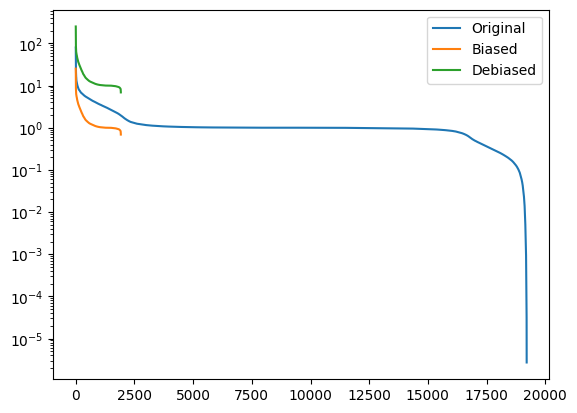

In [33]:
import matplotlib.pyplot as plt

plt.plot(s, label="Original")
plt.plot(s_shuffled, label="Biased")
plt.yscale("log")
plt.legend()

In [32]:
jnp.zeros((3, 2))

Array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 7.000e+00, 1.800e+01,
        1.940e+02, 1.212e+04, 3.942e+03, 1.338e+03, 6.390e+02, 3.560e+02,
        2.020e+02, 1.410e+02, 7.600e+01, 3.500e+01, 3.900e+01, 2.400e+01,
        1.600e+01, 1.300e+01, 9.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
        8.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([-1.36210871, -1.18792689, -1.01374507, -0.83956325, -0.66538143,
        -0.49119958, -0.31701776, -0.14283594,  0.03134588,  0.20552771,
         0.37970954,  0.55389136,  0.72807318,  0.902255  ,  1.07643688,
         1.2506187 ,  1.42480052,  1.59898233,  1.77316415,  1.94734597,
         2.12152767,  2.29570961,  2.46989131,  2.64407325,  2.81825495,
         2.

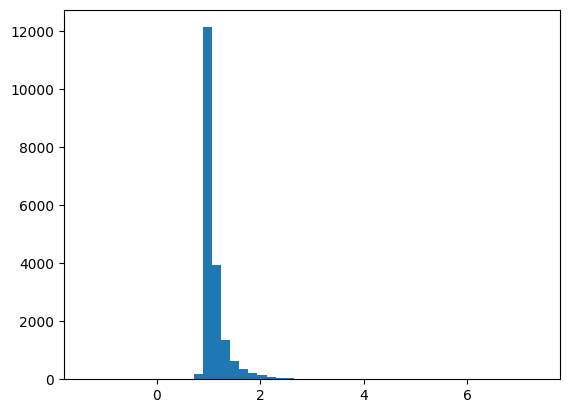

In [3]:
plt.hist(
    jnp.diag(jac), bins=50,
)

In [16]:
diag, _ = estimate_diagonal(raveled_params, X, Y, model.apply, TrainConfig(lr=1e-4), unravel, num_samples=200)
diag

2024-09-01 02:16:24.540929: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 13.38GiB (14370872756 bytes) by rematerialization; only reduced to 20.11GiB (21588291652 bytes), down from 23.23GiB (24942147712 bytes) originally


In [4]:
from imax import randaugment

randaugment.distort_image_with_randaugment(X, num_layers=2, magnitude=9)

(4800010,)

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 4.000000e+00,
        5.000000e+00, 6.000000e+00, 5.000000e+00, 3.900000e+01,
        1.150000e+02, 3.870000e+02, 1.373000e+03, 5.414000e+03,
        2.193800e+04, 9.186500e+04, 3.688370e+05, 2.143289e+06,
        1.701457e+06, 3.497100e+05, 8.686700e+04, 2.138000e+04,
        5.362000e+03, 1.389000e+03, 3.980000e+02, 1.040000e+02,
        3.300000e+01, 1.000000e+01, 6.000000e+00, 2.000000e+00,
        0.000000e+00, 1.000000e+00, 2.000000e+00, 2.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([-0.13564922, -0.10009091, -0.06453261, -0.0289743 ,  0.006584  ,
         0.04214231,  0.07770061,  0.11325891,  0.14881723,  0.18437552,
         0.21993384,  0.25549215,  0.29105043,  

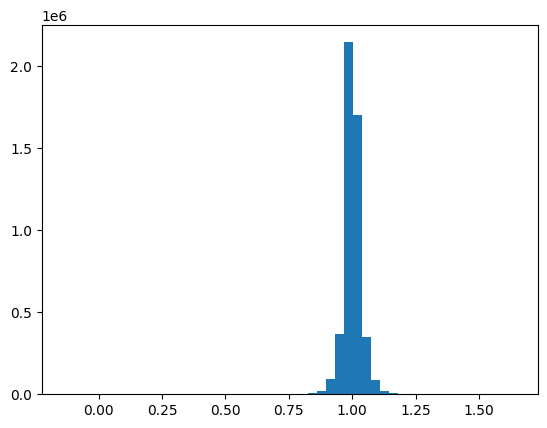

In [13]:
plt.hist(
    diag, bins=50,
)

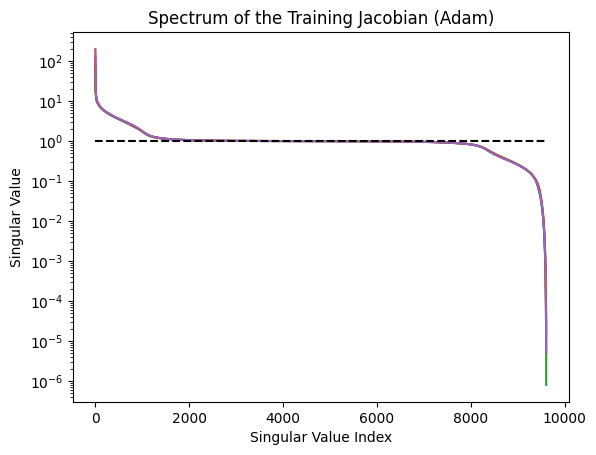

In [ ]:
for s in spectra:
    plt.plot(s)
plt.hlines(
    1, 0, len(jac), color='black', linestyles='dashed'
)
plt.title("Spectrum of the Training Jacobian (Adam)")
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.yscale('log')

In [ ]:
# mask for singular values near one
mask = (s > 0.95) & (s < 1.05)
P_u = u[:, mask] @ u[:, mask].T
P_vt = vt[mask, :].T @ vt[mask, :]

In [ ]:
jnp.linalg.norm(P_u @ raveled_params - P_vt @ final_params) / jnp.linalg.norm(P_u @ raveled_params)

Array(0.2442689, dtype=float32)

In [ ]:
mask.sum() / len(mask)

Array(0.52601457, dtype=float32)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 8.000e+00, 1.400e+01,
        9.000e+00, 1.100e+01, 1.800e+01, 1.800e+01, 1.600e+01, 2.100e+01,
        2.900e+01, 3.000e+01, 4.100e+01, 5.000e+01, 6.600e+01, 4.900e+01,
        7.600e+01, 7.900e+01, 8.600e+01, 1.030e+02, 1.270e+02, 1.510e+02,
        1.410e+02, 1.590e+02, 1.690e+02, 1.910e+02, 2.310e+02, 3.040e+02,
        3.760e+02, 5.830e+02, 7.520e+02, 9.980e+02, 1.283e+03, 1.150e+03,
        7.560e+02, 1.491e+03]),
 array([0.40043801, 0.41243002, 0.42442203, 0.43641403, 0.44840604,
        0.46039805, 0.47239006, 0.48438209, 0.4963741 , 0.50836611,
        0.52035809, 0.53235012, 0.5443421 , 0.55633414, 0.56832618,
        0.58031815, 0.59231019, 0.60430217, 0.61629421, 0.62828618,
        0.64027822, 0.6522702 , 0.66426224, 0.67625421, 0.68824625,
        0.70023823, 0.71223027, 0.72

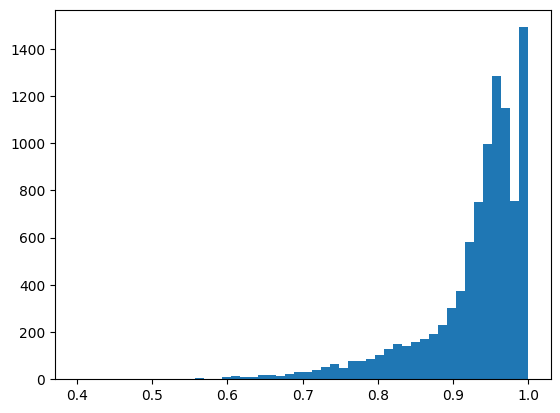

In [ ]:
import matplotlib.pyplot as plt

similarities = jnp.sum(u * vt.T, axis=1)
plt.hist(similarities, bins=50)

In [2]:
# Create a random symmetric matrix
n = 2000
key = jax.random.PRNGKey(42)
A = jax.random.normal(key, (n, n))
A = 0.5 * (A + A.T)

2024-08-31 16:54:09.460922: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [15]:
train_fn = partial(
    train, data=X, labels=Y, apply_fn=model.apply, cfg=cfg, unraveler=unravel
)
_, jvp = jax.linearize(train_fn, raveled_params)
eigvals, densities = lanczos_quadrature_svd(jvp, 100, len(raveled_params))

2024-08-31 18:15:36.364139: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 13.37GiB (14356730550 bytes) by rematerialization; only reduced to 22.35GiB (24003812156 bytes), down from 22.36GiB (24008776592 bytes) originally
E0831 18:24:16.333917 2773392 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: INTERNAL: Failed to allocate 1146880000 bytes for new constant


XlaRuntimeError: INTERNAL: Failed to allocate 1146880000 bytes for new constant

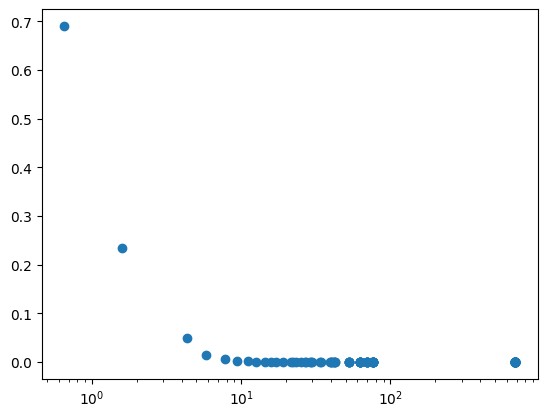

In [13]:
plt.scatter(
    eigvals, densities
)
plt.xscale('log')

In [24]:
lanczos_quadrature_svd(lambda v: A @ v, 100, len(A))

(Array([ 0.45540968,  1.4115188 ,  2.4944892 ,  3.4003801 ,  4.3997955 ,
         5.325297  ,  6.3372235 ,  7.2854395 ,  8.2193775 ,  9.2907    ,
        10.215522  , 11.191184  , 12.166934  , 13.087928  , 14.011752  ,
        15.008441  , 15.945832  , 16.896164  , 17.75795   , 18.749363  ,
        19.649734  , 20.494286  , 21.54487   , 22.438095  , 23.30312   ,
        24.23465   , 25.173742  , 26.028666  , 26.909483  , 27.82344   ,
        28.611822  , 29.45551   , 30.376127  , 31.284779  , 32.091297  ,
        32.920273  , 33.70052   , 34.55226   , 35.332195  , 36.101357  ,
        37.02469   , 37.66334   , 38.522972  , 39.227306  , 40.062588  ,
        40.739372  , 41.5265    , 42.174957  , 42.998837  , 43.603607  ,
        44.308643  , 45.010883  , 45.720848  , 46.35923   , 47.01458   ,
        47.60688   , 48.22849   , 48.748207  , 49.481167  , 50.048275  ,
        50.5757    , 51.156246  , 51.750015  , 52.35404   , 52.891376  ,
        53.413918  , 53.77218   , 54.363327  , 54.7

In [20]:
jnp.cumsum(V[0, :] ** 2)

Array([0.0250467 , 0.0411341 , 0.0616606 , 0.08519582, 0.10161965,
       0.12211649, 0.14300278, 0.15886368, 0.1760249 , 0.19536532,
       0.21266946, 0.23147736, 0.25398114, 0.2712323 , 0.29300487,
       0.31507993, 0.33672047, 0.3592944 , 0.37474382, 0.38974094,
       0.41154006, 0.42805666, 0.43958262, 0.45572716, 0.46689886,
       0.4846183 , 0.499124  , 0.51511955, 0.53310025, 0.5484224 ,
       0.56209505, 0.5773705 , 0.58695966, 0.5993303 , 0.61523306,
       0.63035876, 0.6454608 , 0.656006  , 0.6759556 , 0.6867034 ,
       0.69881606, 0.71122205, 0.72272676, 0.7312279 , 0.7424692 ,
       0.7569815 , 0.76692784, 0.7767403 , 0.78572845, 0.80210483,
       0.8111058 , 0.82290566, 0.8298337 , 0.84372294, 0.85346264,
       0.8648895 , 0.8721112 , 0.8806984 , 0.8855018 , 0.89295036,
       0.89840204, 0.9014449 , 0.9047989 , 0.9087778 , 0.91449994,
       0.9210614 , 0.9308654 , 0.9352808 , 0.9392191 , 0.9428895 ,
       0.95257545, 0.9560331 , 0.9591535 , 0.9637847 , 0.96717

In [21]:
import math

def gaussian_kernel(sigma: float) -> jnp.ndarray:
    """Creates a 1D Gaussian kernel."""
    size = math.ceil(3 * sigma) * 2 + 1

    x = jnp.arange(-size // 2 + 1, size // 2 + 1)
    kernel = jnp.exp(-x**2 / (2 * sigma**2))
    return kernel / jnp.sum(kernel)  # Normalize the kernel

raw = V[0, :] ** 2
smoothed = jnp.convolve(gaussian_kernel(2), raw, mode='same')

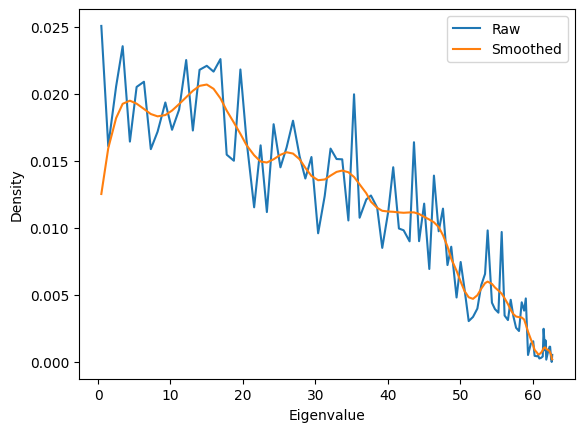

In [22]:
import matplotlib.pyplot as plt

plt.plot(
    D ** 0.5,
    raw,
    label='Raw'
)
plt.plot(
    D ** 0.5,
    smoothed,
    label='Smoothed'
)
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()

(array([251., 250., 245., 238., 224., 211., 195., 168., 133.,  85.]),
 array([1.40822185e-02, 6.28116608e+00, 1.25482502e+01, 1.88153343e+01,
        2.50824184e+01, 3.13495026e+01, 3.76165848e+01, 4.38836708e+01,
        5.01507530e+01, 5.64178391e+01, 6.26849213e+01]),
 <BarContainer object of 10 artists>)

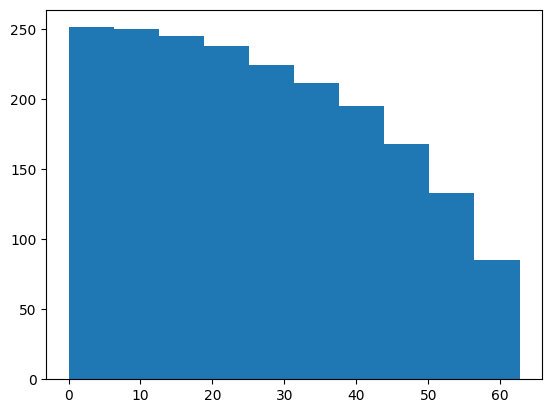

In [16]:
plt.hist(
    jnp.linalg.svdvals(A)
)

In [125]:
from jax.scipy.linalg import eigh_tridiagonal

In [163]:
lanczos_tridiagonalization_scan(A, 5)

(Array([[ 0.514633  , 23.432848  ,  0.        ,  0.        ,  0.        ],
        [23.432848  , -0.28366253, 22.188753  ,  0.        ,  0.        ],
        [ 0.        , 22.188753  ,  1.0207515 , 21.806753  ,  0.        ],
        [ 0.        ,  0.        , 21.806753  ,  1.4707911 , 23.212934  ],
        [ 0.        ,  0.        ,  0.        , 23.212934  ,  0.6536789 ]],      dtype=float32),
 Array([[-0.05089022, -0.00932768, -0.03267247,  0.01631807, -0.01302316],
        [-0.01902488, -0.02497256,  0.00492183,  0.00166117,  0.03447847],
        [-0.00499117, -0.01800207, -0.00815441,  0.05432703,  0.01562736],
        ...,
        [-0.01391701, -0.0219701 ,  0.02345868, -0.00564264,  0.01860283],
        [-0.02026341, -0.0258177 ,  0.07281756,  0.03963217,  0.04202988],
        [-0.00593136, -0.04266467,  0.00632653, -0.00196678,  0.0039168 ]],      dtype=float32))

In [128]:
def sparse_eigensolver(A, k):
    """
    Compute a few eigenvalues and eigenvectors of a large sparse symmetric matrix A.
    
    Args:
    A: The symmetric sparse matrix. Shape (n, n).
    k: The number of Lanczos steps to perform.

    Returns:
    eigenvalues: The approximate eigenvalues of A. Shape (k,)
    eigenvectors: The approximate eigenvectors of A. Shape (n, k)
    """
    # Step 1: Lanczos tridiagonalization
    T, V = lanczos_tridiagonalization_scan(A, k)
    
    # Step 2: Eigen decomposition of the tridiagonal matrix
    eigenvalues = eigh_tridiagonal(T.diagonal(), T.diagonal(offset=-1), eigvals_only=True)
    return eigenvalues


In [147]:
sparse_eigensolver(A, 5)

Array([-4.2187104, -2.7677817, -0.5360018,  3.2644033,  4.8274536],      dtype=float32)

In [148]:
jnp.linalg.eigvalsh(A)

Array([-5.931814  , -4.583691  , -4.022268  , -3.4708254 , -3.0275981 ,
       -2.6784277 , -1.7497247 , -0.85634184, -0.14080405,  0.5004131 ,
        1.0823448 ,  1.1382476 ,  1.5928428 ,  2.0080569 ,  2.8240743 ,
        3.429844  ,  3.616305  ,  4.1321836 ,  4.803182  ,  5.316215  ],      dtype=float32)